In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.fft as fft  #we use scipy for the fft
import pandas as pd 

# 0. Function define 

## 0.1 Fourrier transform 

In [2]:
import numpy as np
from scipy.fft import fft, fftfreq

def PSD(signal, Fs):
    # Number of samples in the signal
    N = len(signal)
    
    # Compute the FFT values
    fft_values = fft(signal)
    
    # Compute the corresponding frequencies
    freq = fftfreq(N, 1 / Fs)
    
    # Only keep the positive frequencies
    pos_mask = freq >= 0
    
    # Return the positive frequencies and their magnitudes
    return freq[pos_mask], 2*np.abs(fft_values[pos_mask])/N

## 0.2 Power Spectral Density

In [3]:
def compute_fourier_transform(signal, sample_rate):
    """
    Computes the Fourier Transform of a given signal.
    
    Parameters:
    signal (numpy array): The input signal to be transformed.
    sample_rate (float): The sampling rate of the signal (in Hz).
    
    Returns:
    freq (numpy array): Frequencies corresponding to the Fourier Transform.
    amplitude (numpy array): Amplitude of the Fourier Transform at the given frequencies.
    """
    # Number of sample points
    N = len(signal)
    
    # Compute the Fourier Transform
    yf = fft(signal)
    
    # Compute the frequency bins
    xf = fftfreq(N, 1/sample_rate)[:N//2]
    
    # Compute the amplitude spectrum
    amplitude = 2.0/N * np.abs(yf[:N//2])
    
    return xf, amplitude

In [4]:

def compute_power_spectral_density(signal, sample_rate, nperseg):
    from scipy.signal import welch
    """
    Computes the Power Spectral Density (PSD) of a given signal using Welch's method.
    
    Parameters:
    signal (numpy array): The input signal.
    sample_rate (float): The sampling rate of the signal (in Hz).
    nperseg (int, optional): Length of each segment for Welch's method (default is 256).
    
    Returns:
    freq (numpy array): Frequencies at which the PSD is computed.
    psd (numpy array): Power Spectral Density at each frequency.
    """
    # Compute the Power Spectral Density using Welch's method
    freq, psd = welch(signal, sample_rate, nperseg=nperseg)
    return freq, np.sqrt(psd)
    

In [5]:
def compute_power_spectral_density(signal, sample_rate, nperseg, bandwidth):
    from scipy.signal import welch
    from scipy.signal.windows import hann
    """
    Computes the Power Spectral Density (PSD) of a given signal using Welch's method,
    considering the bandwidth of the oscilloscope.

    Parameters:
    signal (numpy array): The input signal.
    sample_rate (float): The sampling rate of the signal (in Hz).
    nperseg (int, optional): Length of each segment for Welch's method (default is 256).
    bandwidth (float): Bandwidth of the oscilloscope (in Hz).

    Returns:
    freq (numpy array): Frequencies at which the PSD is computed.
    psd (numpy array): Power Spectral Density at each frequency.
    """

    # Apply a Hanning window to the signal
    window = hann(nperseg)
    signal = signal * window

    # Compute the Power Spectral Density using Welch's method
    freq, psd = welch(signal, sample_rate, nperseg=nperseg)

    # Consider the oscilloscope's bandwidth
    valid_indices = freq <= bandwidth / 2  # Keep only frequencies within bandwidth
    freq = freq[valid_indices]
    psd = psd[valid_indices]

    return freq, np.sqrt(psd)
    

In [6]:
def PSD_avg(data, Fs, BW, nperseg):  # Added nperseg argument
    """
    Computes the average Power Spectral Density (PSD) of a given signal 
    over multiple segments.

    Parameters:
    data (numpy array): The input signal.
    Fs (float): The sampling rate of the signal (in Hz).
    BW (float): Bandwidth of the oscilloscope (in Hz).
    nperseg (int, optional): Length of each segment for Welch's method (default is 256).

    Returns:
    freq (numpy array): Frequencies at which the PSD is computed.
    avg_psd (numpy array): Average Power Spectral Density at each frequency.
    """
    L = len(data)
    n = int(L / Fs) 
    # print(n)
    psd_sum = np.zeros(L // n // 2 +1)  # Initialize array to store PSD sum
    # print(np.size(psd_sum))
    count = 0
    for i in range(n):
        # print(i)
        fre, val = compute_power_spectral_density(data[count:count + Fs], Fs, nperseg, BW)
        psd_sum += val 
        count += Fs

    avg_psd = psd_sum / n
    return fre, avg_psd  # Return the frequency array from the last segment
        

# 1. Noise plot 

### Compare

In [330]:
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'] 


In [331]:
color[5]

'#8c564b'

<!-- In this analysis, there are something to note: 

1. The DAC's voltage measured within 10s by the Oscilloscope with BW = 1 GHz
2. DAC voltage converted into current using the relation below:
       $$ \sqrt{S_I} = \frac{n_{out}*2}{1000*510} = \frac{n_{out \times 2}}{510000}  * 10^{12} [pA]  $$ ($10^{12}$ to convert it into $pA$)
3. Data taken by Oscilloscope in 20s. With $Fs = 20 kHz$ -->

Plot the measurement on different Asics Boards using different power source

* The power supply
* The filtered power supply
* The batteries 

## 1.1. AwaXe v4 

In the measurement of AwaXe v4, we use impedance = $1 M \Omega$ 

### 1.1.1 Read data 

Note that the file's name can be understand with the following instruction:

``` B [board number] + [ULTRA LOW FREQUENCY /LOW FREQUENCY/ HIGH FREQUENCY] + [Type of power source] ```


For example: ``` B5LFPS ``` : Board 5, Low frequency, power supply 

P/s: 

```UF ``` Ultra low frequency (from 0.1 to 10 Hz)

```LF ``` Low frequency (from 1 to 100 Hz)

```HF ``` High frequency (from 10 to 1000 Hz)



```PS ``` Power supply

```FF ``` Filtered Power Supply

```BA ``` Batteries 



------------------------

* Gain $G = \frac{1e12}{510 \times 1000} $ if **impedance** = $50 \Omega$  
* Gain $G = \frac{1e12}{2 \times 510 \times 1000} $ if **impedance** = $1M \Omega$
-------------------------


In [296]:
factor = 1e12 / (510 * 1000) #with impedance 50 Ohm
factor1 = factor /2

In [297]:
color = ['black', 'orange', 'green', 'red', 'brown']

In [298]:
B5LFPS = np.genfromtxt('data/AwaXev4_error/B5LFPS.TXT')
B5HFPS = np.genfromtxt('data/AwaXev4_error/B5HFPS.TXT')
B5LFFF = np.genfromtxt('data/AwaXev4_error/B5LFFF.TXT')
B5HFFF = np.genfromtxt('data/AwaXev4_error/B5HFFF.TXT')
B5LFBA = np.genfromtxt('data/AwaXev4_error/B5LFBA.TXT')
B5HFBA = np.genfromtxt('data/AwaXev4_error/B5HFBA.TXT')

### AwaXe v4 Board 5
 measure current density from TES DAC. Using spectral analyser 

Text(0.5, 1.0, ' DAC TES Current density measured in board 5 AwaXe v4')

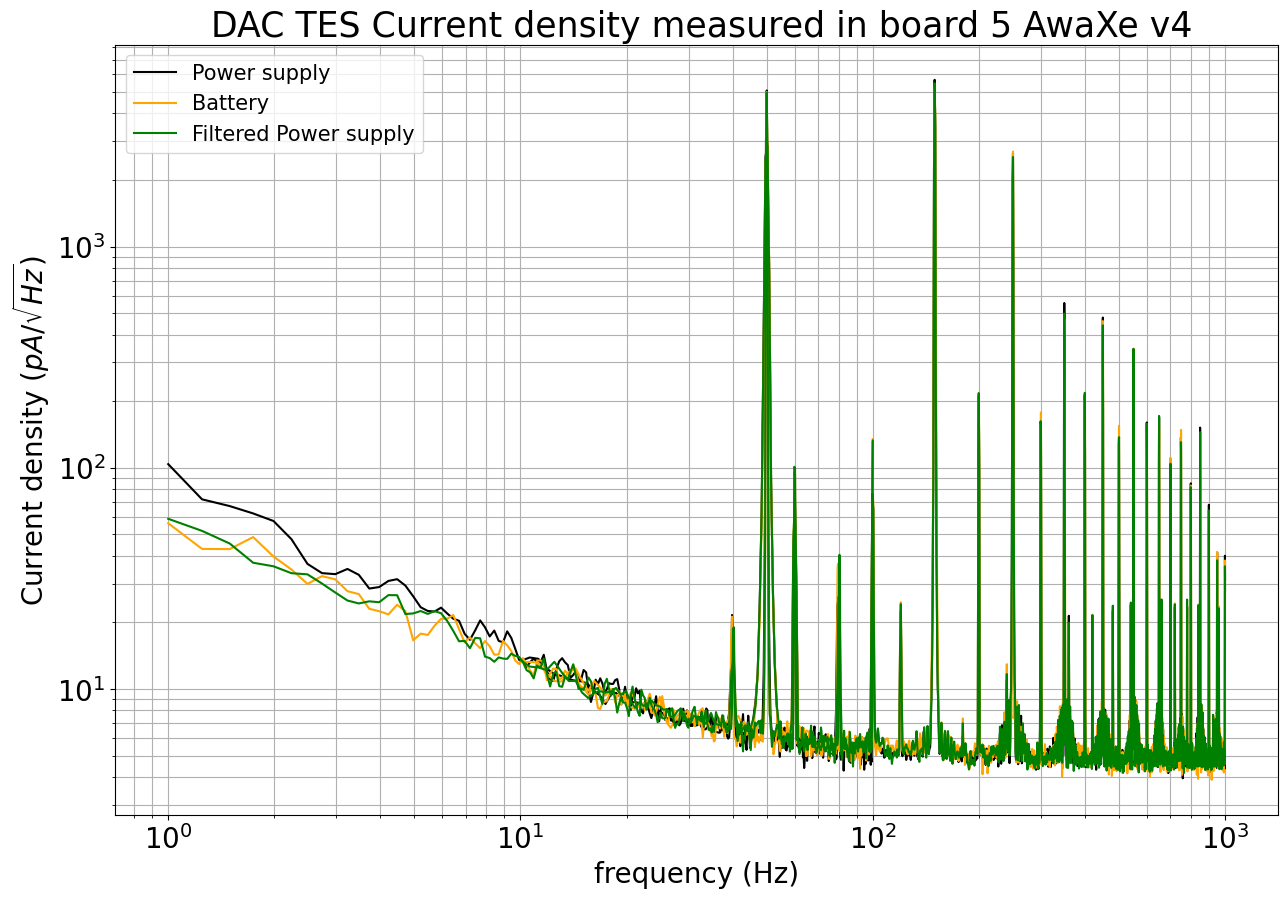

In [299]:
plt.figure(figsize = (15,10))
# plt.subplot(211)
plt.loglog(B5LFPS[:,0], B5LFPS[:,1]*factor1, color = color[0], label = 'Power supply' )
plt.loglog(B5HFPS[:,0], B5HFPS[:,1]*factor1, color = color[0] )
plt.loglog(B5LFBA[:,0], B5LFBA[:,1]*factor1, color = color[1], label = 'Battery' )
plt.loglog(B5HFBA[:,0], B5HFBA[:,1]*factor1, color = color[1] )
plt.loglog(B5LFFF[:,0], B5LFFF[:,1]*factor1, color = color[2], label = 'Filtered Power supply' )
plt.loglog(B5HFFF[:,0], B5HFFF[:,1]*factor1, color = color[2] )

plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r'Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.title(' DAC TES Current density measured in board 5 AwaXe v4',fontsize = 25) 


Anyway, the next day we realised that we didn't connect the board while measuring... So this one just plot the ambient noise

### 1.1.2. AwaXe v4, board 4

From now on, we will distinguished between TES DAC and SQUID DAC, so that we propose different way to name them 


``` [DAC type] + [board number] + [ULTRA LOW FREQUENCY /LOW FREQUENCY/ HIGH FREQUENCY] + [Type of power source] ```


For example: ``` S4LFPS ``` : Squid DAC, Board 4, Low frequency, power supply 

P/s: 

*DAC type*

``` S ``` Squid 

``` T ``` TES 


*Frequency range*

```UF ``` Ultra low frequency (from 0.1 to 10 Hz)

```LF ``` Low frequency (from 1 to 100 Hz)

```HF ``` High frequency (from 10 to 1000 Hz)


*Type of power supply*

```PS ``` Power supply

```FF ``` Filtered Power Supply

```BA ``` Batteries 

In [300]:
S4LFPS = np.genfromtxt('data/AwaXev4/S4LFPS.TXT')
S4HFPS = np.genfromtxt('data/AwaXev4/S4HFPS.TXT')
S4LFFF = np.genfromtxt('data/AwaXev4/S4LFFF.TXT')
S4HFFF = np.genfromtxt('data/AwaXev4/S4HFFF.TXT')
S4LFBA = np.genfromtxt('data/AwaXev4/S4LFBA.TXT')
S4HFBA = np.genfromtxt('data/AwaXev4/S4HFBA.TXT')
T4LFPS = np.genfromtxt('data/AwaXev4/T4LFPS.TXT')
T4HFPS = np.genfromtxt('data/AwaXev4/T4HFPS.TXT') 
T4LFFF = np.genfromtxt('data/AwaXev4/T4LFFF.TXT')
T4HFFF = np.genfromtxt('data/AwaXev4/T4HFFF.TXT')
T4LFBA = np.genfromtxt('data/AwaXev4/T4LFBA.TXT')
T4HFBA = np.genfromtxt('data/AwaXev4/T4HFBA.TXT')

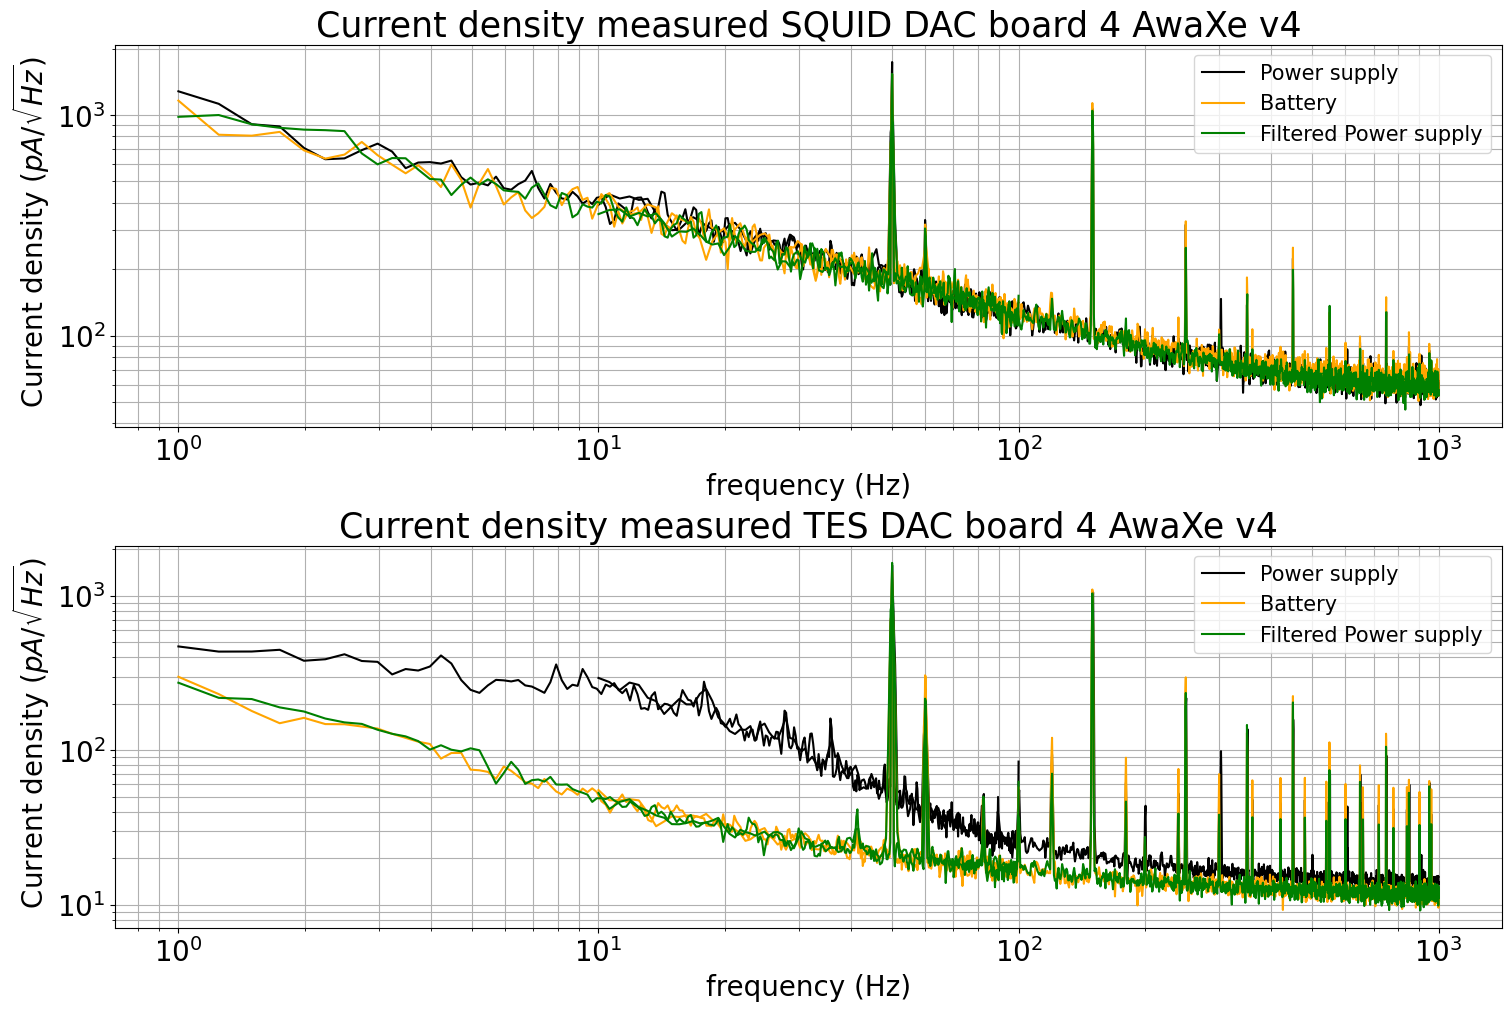

In [301]:

plt.figure(figsize = (15,10), constrained_layout=True)
plt.subplot(211)
plt.loglog(S4LFPS[:,0], S4LFPS[:,1]*factor1, color = color[0], label = 'Power supply' )
plt.loglog(S4HFPS[:,0], S4HFPS[:,1]*factor1, color = color[0] )
plt.loglog(S4LFBA[:,0], S4LFBA[:,1]*factor1, color = color[1], label = 'Battery' )
plt.loglog(S4HFBA[:,0], S4HFBA[:,1]*factor1, color = color[1] )
plt.loglog(S4LFFF[:,0], S4LFFF[:,1]*factor1, color = color[2], label = 'Filtered Power supply' )
plt.loglog(S4HFFF[:,0], S4HFFF[:,1]*factor1, color = color[2] )
plt.gca().set_title('Current density measured SQUID DAC board 4 AwaXe v4',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.loglog(T4LFPS[:,0], T4LFPS[:,1]*factor1, color = color[0], label = 'Power supply' )
plt.loglog(T4HFPS[:,0], T4HFPS[:,1]*factor1, color = color[0] )
plt.loglog(T4LFBA[:,0], T4LFBA[:,1]*factor1, color = color[1], label = 'Battery' )
plt.loglog(T4HFBA[:,0], T4HFBA[:,1]*factor1, color = color[1] )
plt.loglog(T4LFFF[:,0], T4LFFF[:,1]*factor1, color = color[2], label = 'Filtered Power supply' )
plt.loglog(T4HFFF[:,0], T4HFFF[:,1]*factor1, color = color[2] )
plt.gca().set_title('Current density measured TES DAC board 4 AwaXe v4',fontsize = 25) 
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('DAC_SQUID_TES_v4_board4.png')

In [302]:
S3LFFF = np.genfromtxt('data/AwaXev4/B3LFFF.TXT')
S3HFFF = np.genfromtxt('data/AwaXev4/B3HFFF.TXT')
S1LFFF = np.genfromtxt('data/AwaXev4/S1LFFF.TXT')
S1HFFF = np.genfromtxt('data/AwaXev4/S1HFFF.TXT')
S4LFFF = np.genfromtxt('data/AwaXev4/S4LFFF.TXT')
S4HFFF = np.genfromtxt('data/AwaXev4/S4HFFF.TXT')

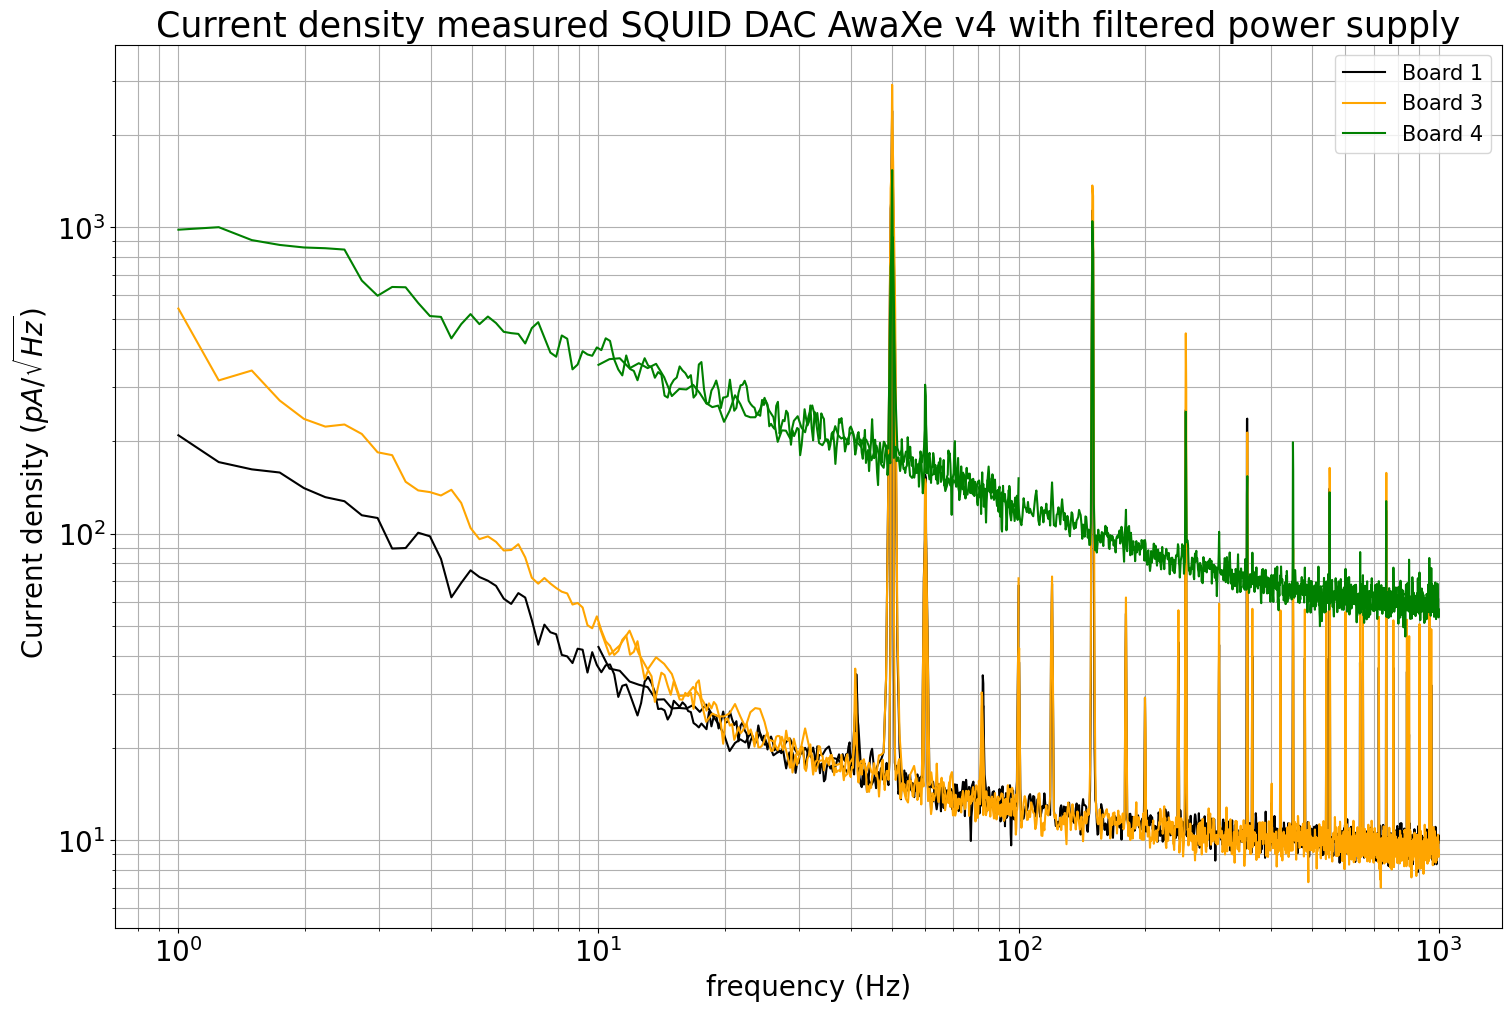

In [303]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)
plt.loglog(S1LFFF[:,0], S1LFFF[:,1]*factor1, color = color[0], label = 'Board 1' )
plt.loglog(S1HFFF[:,0], S1HFFF[:,1]*factor1, color = color[0] )
plt.loglog(S3LFFF[:,0], S3LFFF[:,1]*factor1, color = color[1], label = 'Board 3' )
plt.loglog(S3HFFF[:,0], S3HFFF[:,1]*factor1, color = color[1] )
plt.loglog(S4LFFF[:,0], S4LFFF[:,1]*factor1, color = color[2], label = 'Board 4' )
plt.loglog(S4HFFF[:,0], S4HFFF[:,1]*factor1, color = color[2] )
plt.gca().set_title('Current density measured SQUID DAC AwaXe v4 with filtered power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('DAC_SQUID_DAC_v4.png')

## 1.2 AwaXe v4.5

Not like **AwaXev4**, the ASIC board **AwaXev4.5** has 2 TES DAC and 2 SQUID DAC. So we have to name the file in different way 


``` [Board number] + [45] + [DAC type] + [DAC order] + [ULTRA LOW FREQUENCY /LOW FREQUENCY/ HIGH FREQUENCY] + [Type of power source] ```


For example: ``` 345T2LPS ``` : Board 3, AwaXe4.5, TES 2, Low frequency, Power supply  

P/s: 

*DAC type*

``` S ``` Squid 

``` T ``` TES 


*Frequency range*

```U ``` Ultra low frequency (from 0.1 to 10 Hz)

```L ``` Low frequency (from 1 to 100 Hz)

```H ``` High frequency (from 10 to 1000 Hz)


*Type of power supply*

```PS ``` Power supply

```FF ``` Filtered Power Supply

```BA ``` Batteries 

### 1.2.1. Board 3

For this board, we also measure the data using osciloscope in order to compare with the spectral analyser and unify the analysing way for Oscilloscope's data 

In [304]:
TES1_LF      = np.genfromtxt('data/AwaXev4.5/345T1LPS.TXT') 
TES2_LF      = np.genfromtxt('data/AwaXev4.5/345T2LPS.TXT') 
TES1_HF      = np.genfromtxt('data/AwaXev4.5/345T1HPS.TXT') 
TES2_HF      = np.genfromtxt('data/AwaXev4.5/345T2HPS.TXT')
SQI1_LF      = np.genfromtxt('data/AwaXev4.5/345S1LPS.TXT') 
SQI2_LF      = np.genfromtxt('data/AwaXev4.5/345S2LPS.TXT')
SQI1_HF      = np.genfromtxt('data/AwaXev4.5/345S1HPS.TXT') 
SQI2_HF      = np.genfromtxt('data/AwaXev4.5/345S2HPS.TXT')
TES2_UF      = np.genfromtxt('data/AwaXev4.5/345T2UPS.TXT') 
SQI2_UF      = np.genfromtxt('data/AwaXev4.5/345S2UPS.TXT') 
SPECTRO_TES2 = np.genfromtxt('data/AwaXev4.5/CMPT2HPS.TXT')
SPECTRO_SQI2 = np.genfromtxt('data/AwaXev4.5/CMPS2HPS.TXT')
OSCILLO_TES2 =   pd.read_csv('data/AwaXev4.5/cmpt2hps.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_SQI2 =   pd.read_csv('data/AwaXev4.5/cmps2hps.Wfm.csv', skiprows=0, header=None) # No header

#### v4.5, Board 3, with power supply 

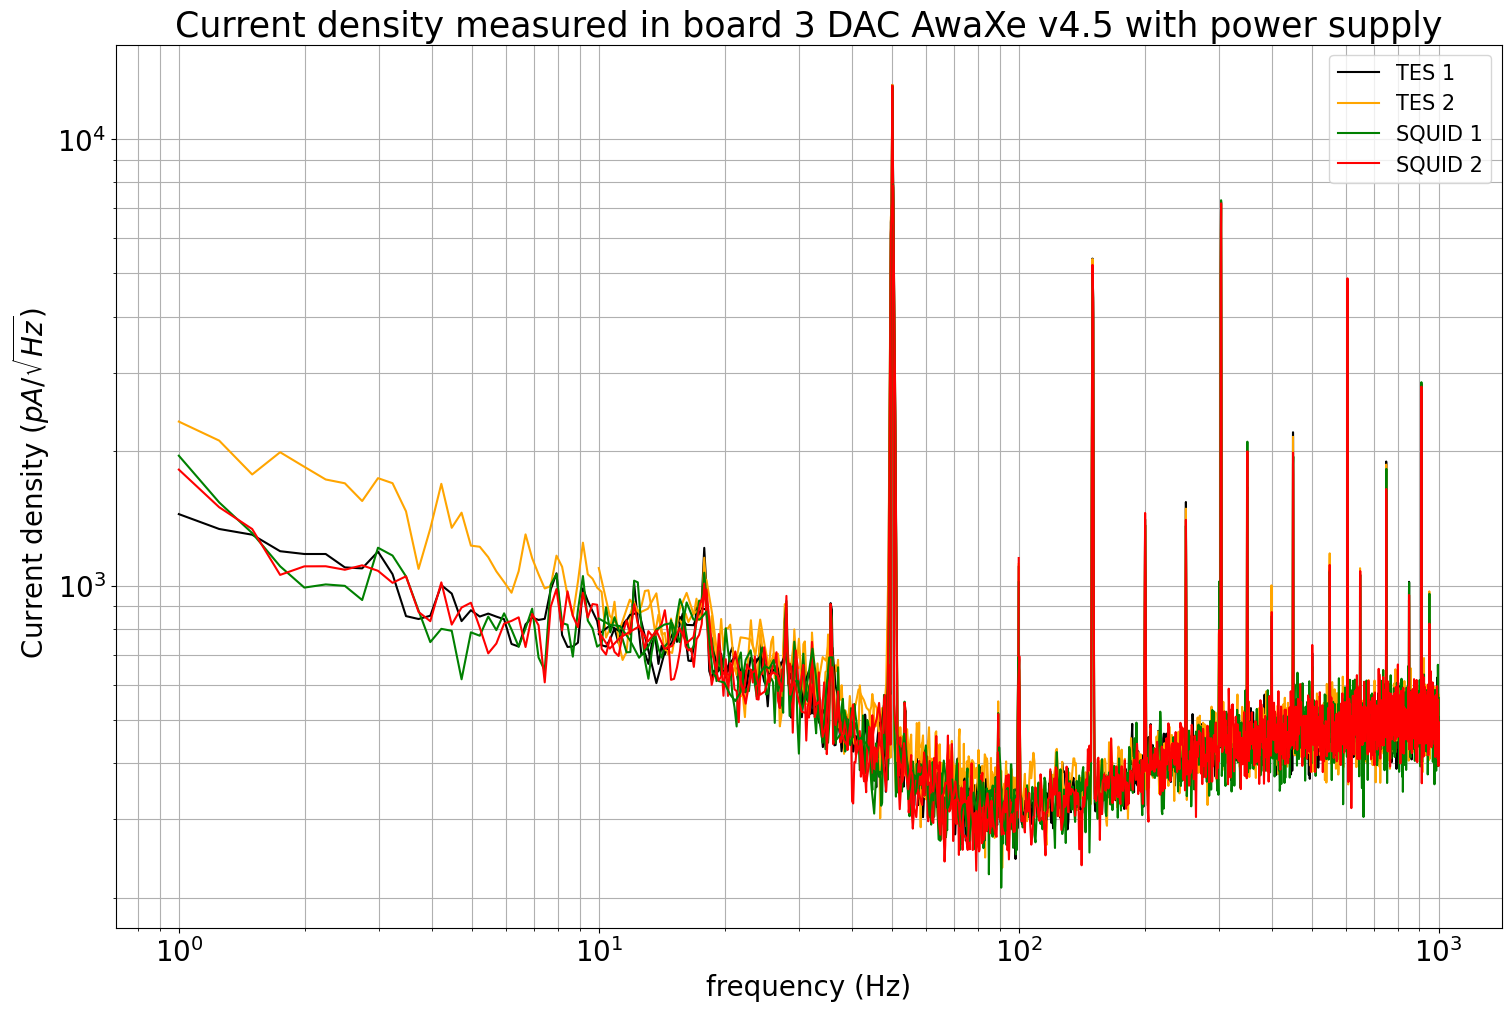

In [305]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

#TES_LF 
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor1, color = color[0], label = 'TES 1' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'TES 2' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor1, color = color[2], label = 'SQUID 1' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'SQUID 2' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )


plt.gca().set_title('Current density measured in board 3 DAC AwaXe v4.5 with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('board3_v4.5_TES12_SQUID12.png')

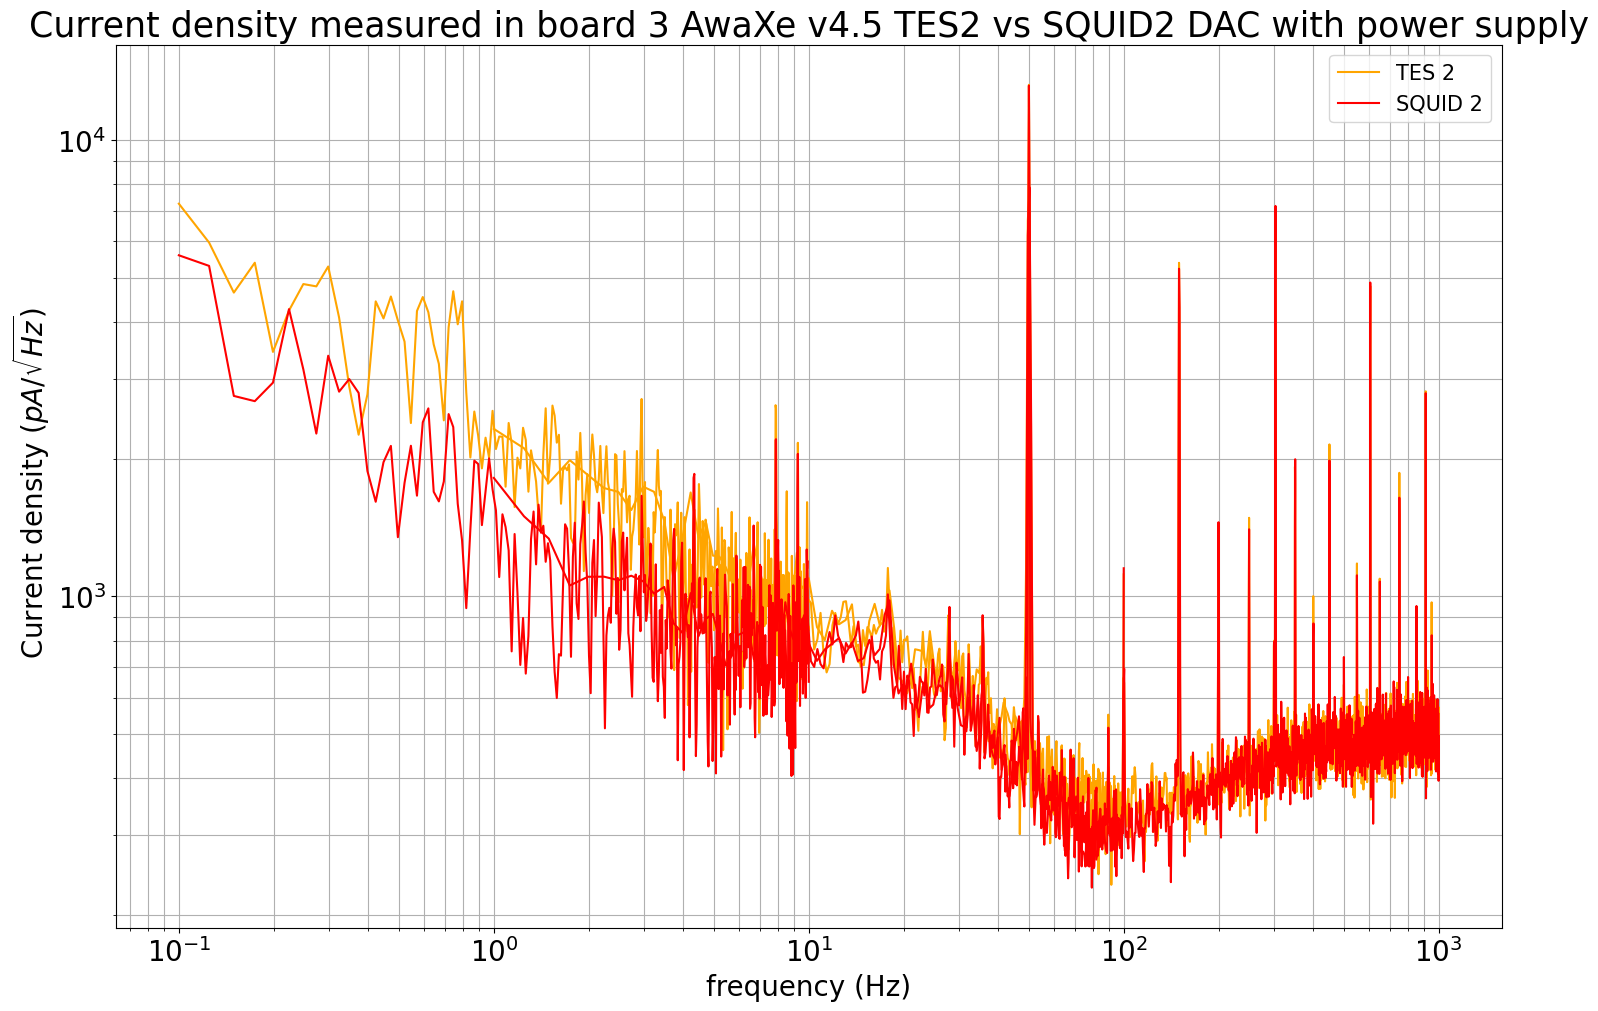

In [306]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)
#TES_UF 
plt.loglog(TES2_UF[:,0], TES2_UF[:,1]*factor1, color = color[1])
#TES_LF 
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'TES 2' )
#TES_HF 
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )
#SQID_UF 
plt.loglog(SQI2_UF[:,0], SQI2_UF[:,1]*factor1, color = color[3] )
#SQUID_LF 
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'SQUID 2' )
#SQUID_HF 
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )


plt.gca().set_title('Current density measured in board 3 AwaXe v4.5 TES2 vs SQUID2 DAC with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.savefig('board3_v4.5_TES2_SQUID2_ultralownoise.png')

<span style="color:red;">Note that in this measurement, the impedance of the oscilloscope is $50 \Omega$. Theoretically, the magnitude will be 2 times less than the measurement  .</span>

In [307]:
sample_rate = 20000
ft1,val1 = compute_power_spectral_density(OSCILLO_TES2[0], sample_rate, len(OSCILLO_TES2[0]), 20e6)
ft2,val2 = compute_power_spectral_density(OSCILLO_SQI2[0], sample_rate, len(OSCILLO_SQI2[0]), 20e6)

(1, 10000.0)

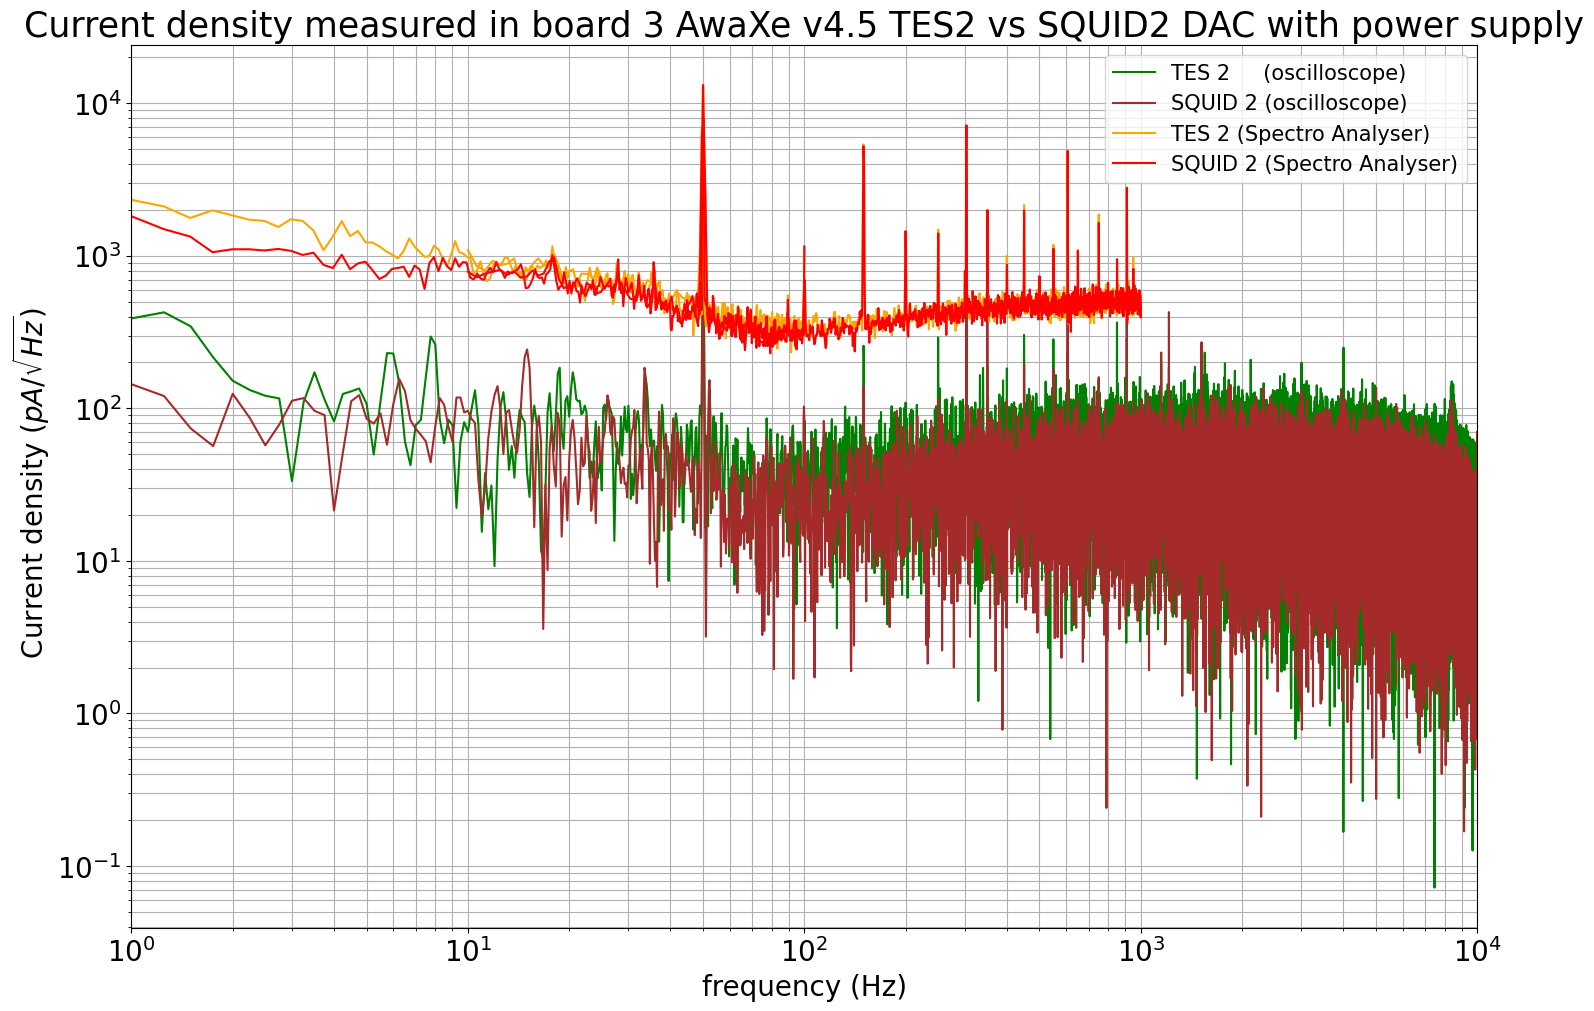

In [308]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

# #TES_LF 
# plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor, color = color[1], label = 'TES 2' )
# #TES_HF 
# plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor, color = color[1] )

# #SQUID_LF 
# plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor, color = color[3], label = 'SQUID 2' )
# #SQUID_HF 
# plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor, color = color[3] )

#Oscilloscope 
plt.loglog(ft1,val1*factor, color = color[2], label = 'TES 2     (oscilloscope)')
plt.loglog(ft2,val2*factor, color = color[4], label = 'SQUID 2 (oscilloscope)')

#TES_LF 
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'TES 2 (Spectro Analyser)' )
#TES_HF 
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )

#SQUID_LF 
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'SQUID 2 (Spectro Analyser)' )
#SQUID_HF 
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )


plt.gca().set_title('Current density measured in board 3 AwaXe v4.5 TES2 vs SQUID2 DAC with power supply',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.xlim(1,1e4)
# plt.savefig('spectrum_compare.png')

We have a few things to take into account now:

* Signal measured by the oscilloscope is the averaging of 10 waveform. Theoretically, the noise's magnitude could be decrease by factor of $\sqrt{10}$.

$ \Rightarrow$ Take into account those two consideration, we can put the two signal into the same scale by multiply the signal measured by oscilloscope by factor of $\sqrt{10}$ 

(1, 10000.0)

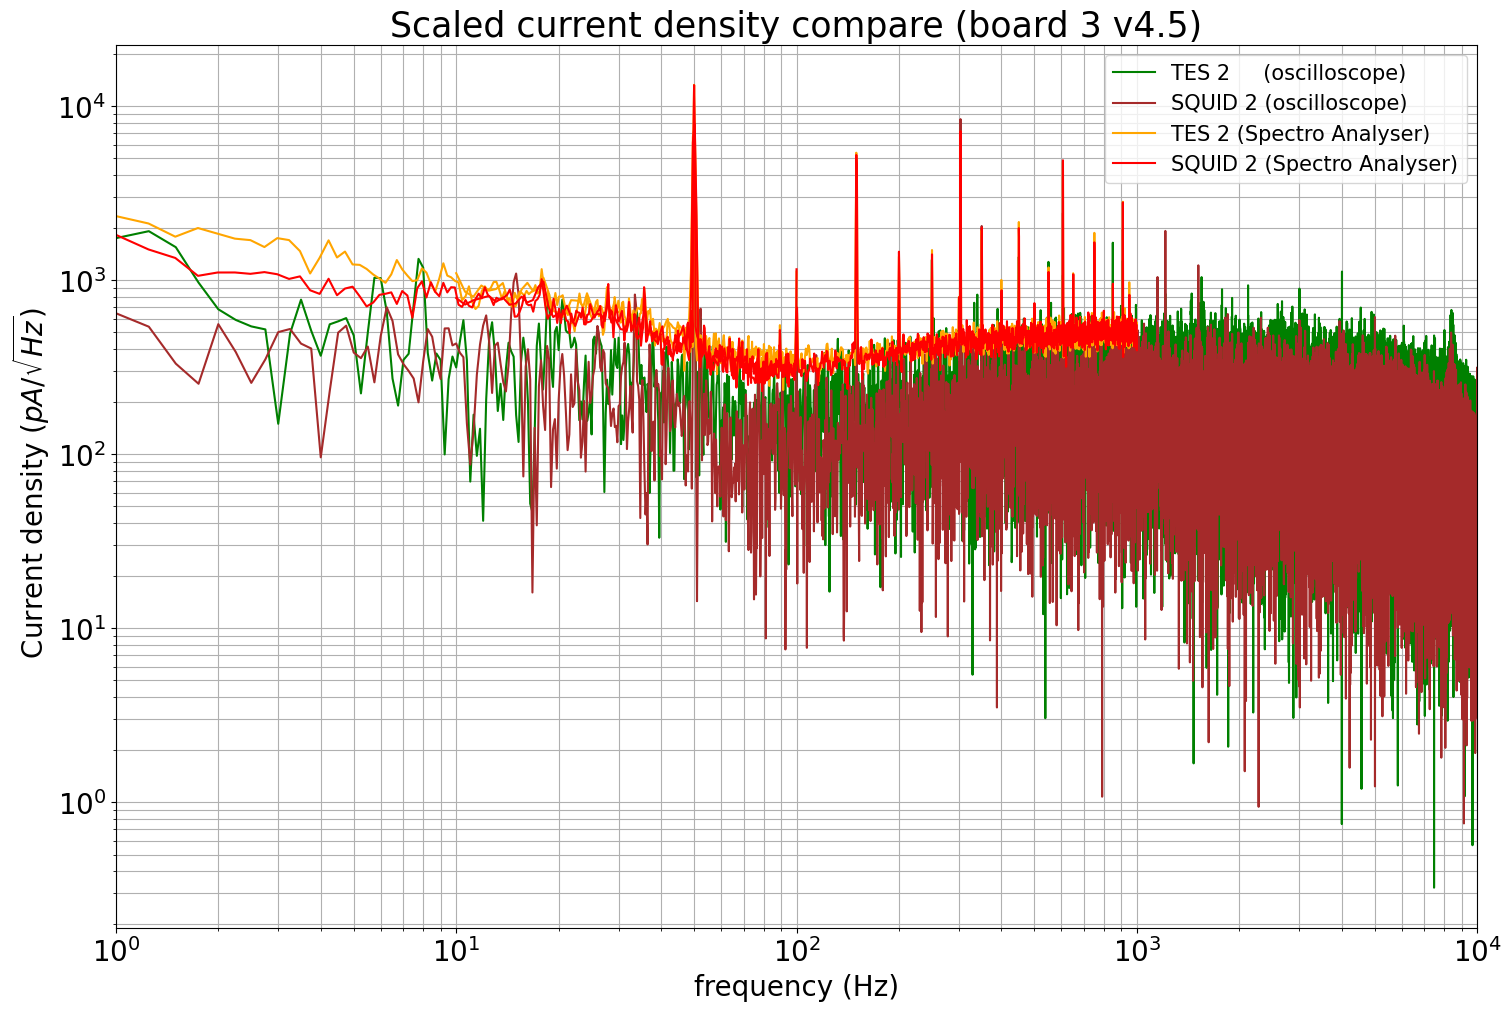

In [309]:
factor2 = factor * (np.sqrt(20)) #scaling signal 2

plt.figure(figsize = (15,10), constrained_layout=True)


plt.loglog(ft1,val1*factor2, color = color[2], label = 'TES 2     (oscilloscope)')
plt.loglog(ft2,val2*factor2, color = color[4], label = 'SQUID 2 (oscilloscope)')

 
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'TES 2 (Spectro Analyser)' )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'SQUID 2 (Spectro Analyser)' ) 
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )


plt.gca().set_title('Scaled current density compare (board 3 v4.5)',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.xlim(1,1e4)
# plt.savefig('spectrum_compare.png')

#### v4.5, board 3 with batteries

In [310]:
### TES_LF
TES1BA_LF = np.genfromtxt('data/AwaXev4.5/345T1LBA.TXT') 
TES2BA_LF = np.genfromtxt('data/AwaXev4.5/345T2LBA.TXT') 
TES1BA_HF = np.genfromtxt('data/AwaXev4.5/345T1HBA.TXT') 
TES2BA_HF = np.genfromtxt('data/AwaXev4.5/345T2HBA.TXT')
SQI1BA_LF = np.genfromtxt('data/AwaXev4.5/345S1LBA.TXT') 
SQI2BA_LF = np.genfromtxt('data/AwaXev4.5/345S2LBA.TXT')
SQI1BA_HF = np.genfromtxt('data/AwaXev4.5/345S1HBA.TXT') 
SQI2BA_HF = np.genfromtxt('data/AwaXev4.5/345S2HBA.TXT')
TES2BA_UF = np.genfromtxt('data/AwaXev4.5/345T2UBA.TXT')
TES2BA_UF = np.genfromtxt('data/AwaXev4.5/345T2UBA.TXT') 
SQI2BA_UF = np.genfromtxt('data/AwaXev4.5/345S2UBA.TXT') 
TES1BA_UF = np.genfromtxt('data/AwaXev4.5/345T1UBA.TXT') 
SQI1BA_UF = np.genfromtxt('data/AwaXev4.5/345S1UBA.TXT') 
# ### DATA to try compare 
# SPECTRO_TES2 = np.genfromtxt('v4.5/CMPT2HPS.TXT')
# SPECTRO_SQI2 = np.genfromtxt('v4.5/CMPS2HPS.TXT')

# OSCILLO_TES2 = pd.read_csv('v4.5/cmpt2hps.Wfm.csv', skiprows=0, header=None) # No header
# OSCILLO_SQI2 = pd.read_csv('v4.5/cmps2hps.Wfm.csv', skiprows=0, header=None) # No header

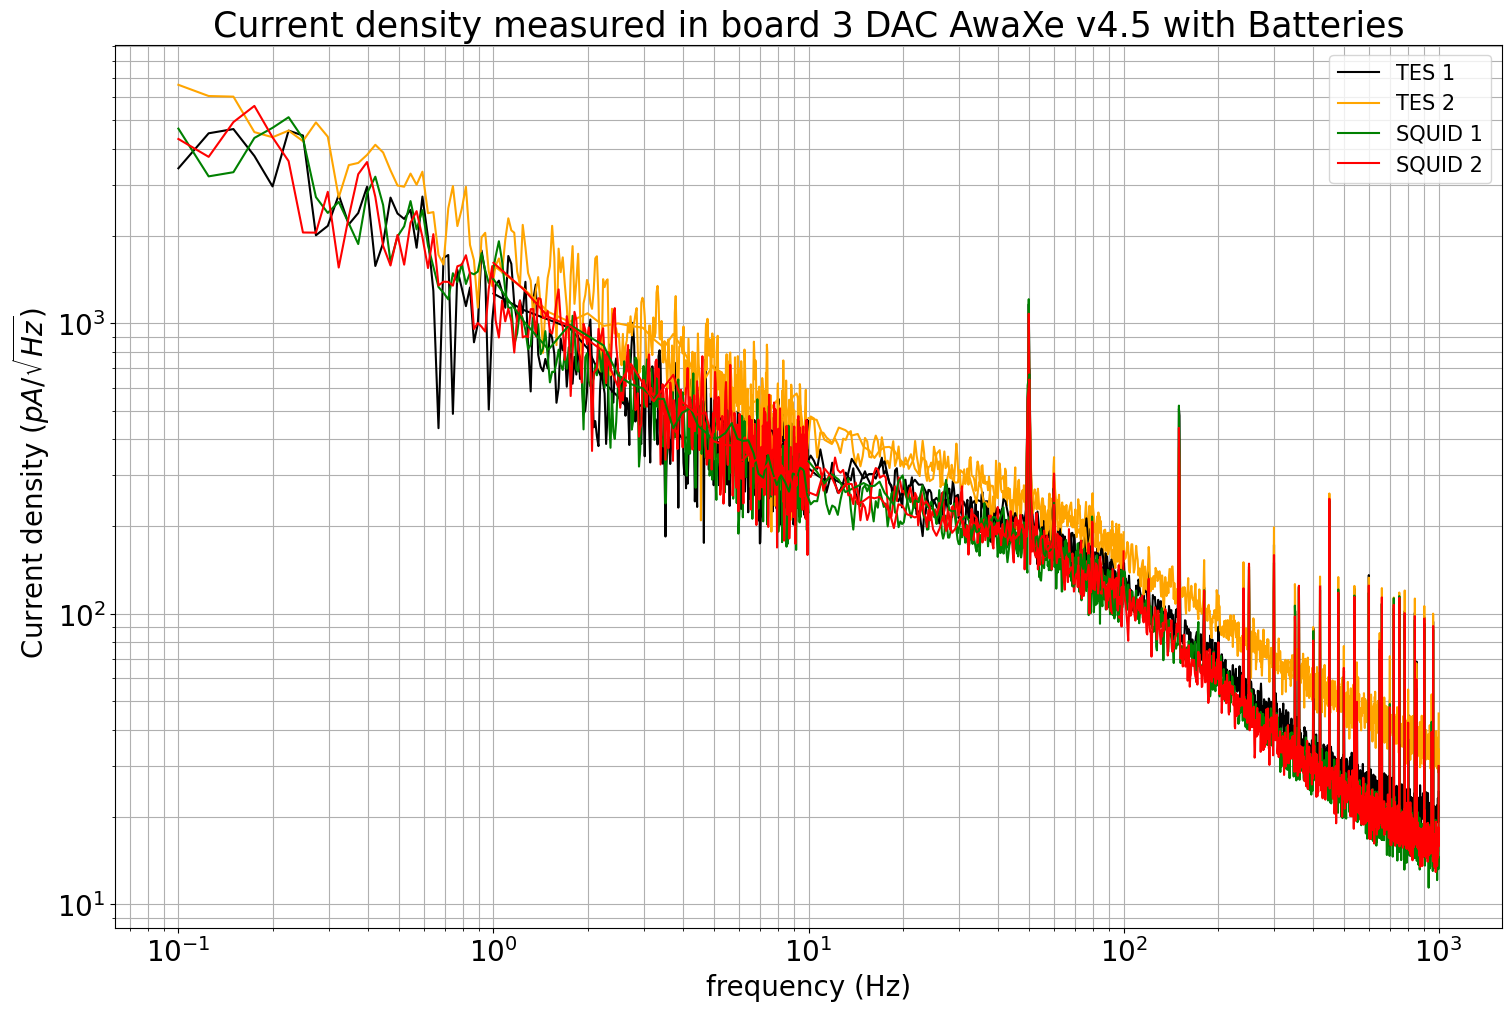

In [311]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

#TES_LF 
plt.loglog(TES1BA_UF[:,0], TES1BA_UF[:,1]*factor1, color = color[0] )
plt.loglog(TES2BA_UF[:,0], TES2BA_UF[:,1]*factor1, color = color[1] )
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor1, color = color[0], label = 'TES 1' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor1, color = color[1], label = 'TES 2' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor1, color = color[1] )

plt.loglog(SQI1BA_UF[:,0], SQI1BA_UF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2BA_UF[:,0], SQI2BA_UF[:,1]*factor1, color = color[3] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor1, color = color[2], label = 'SQUID 1' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor1, color = color[3], label = 'SQUID 2' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor1, color = color[3] )



plt.gca().set_title('Current density measured in board 3 DAC AwaXe v4.5 with Batteries',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

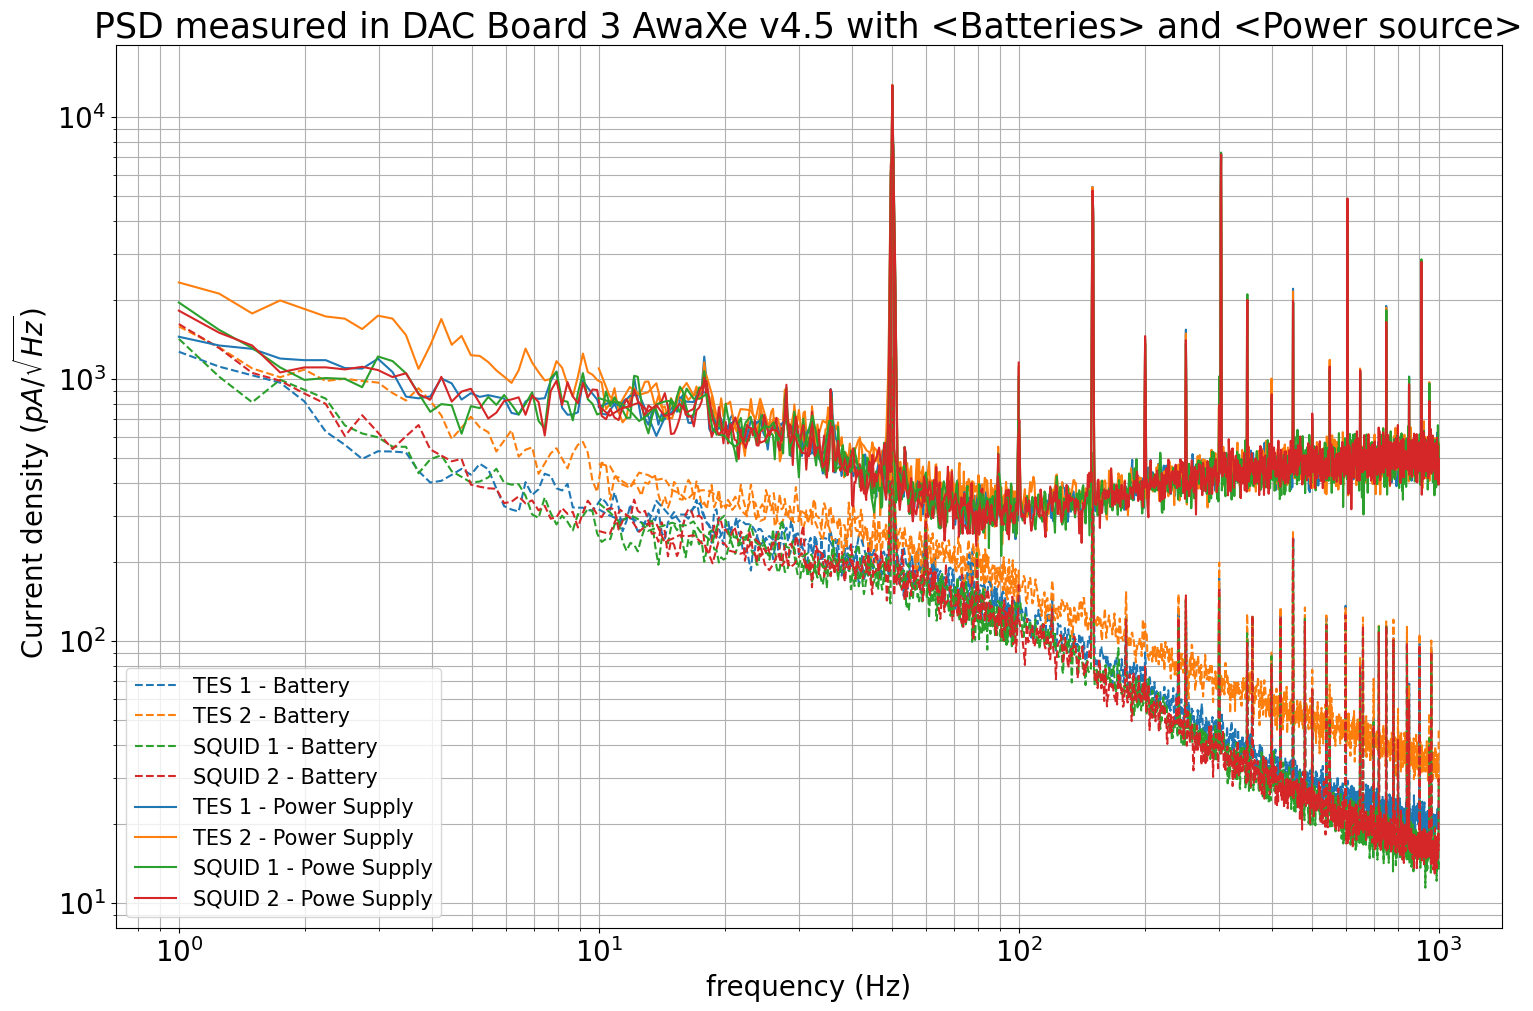

In [378]:
plt.figure(figsize = (15,10), constrained_layout=True)
# plt.subplot(211)

#TES_LF 
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[0], label = 'TES 1 - Battery' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[1], label = 'TES 2 - Battery' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[1] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[2], label = 'SQUID 1 - Battery' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[3], label = 'SQUID 2 - Battery' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[3] )

#------

#TES_LF 
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor1, color = color[0], label = 'TES 1 - Power Supply' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'TES 2 - Power Supply' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor1, color = color[2], label = 'SQUID 1 - Powe Supply' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'SQUID 2 - Powe Supply' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )

plt.gca().set_title('PSD measured in DAC Board 3 AwaXe v4.5 with <Batteries> and <Power source>',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### 1.2.2 Analyse and plot oscilloscope data of v4.5 board 3 (with battery)

Some note for analyse the data:

* Amplified by SR with ``` G = 1000 ``` and with analog LPF ``` Fc = 3kHz ```
* Measure by Oscilloscope with ``` BW = 20 MHz ```
* Measure in ``` T = 40s ```
* Sampling frequency ```Fs = 20 kHz```
* Impedance ``` 50 Ohm ``` 

In [313]:
### Oscilloscope 

OSCILLO_TES2BA = pd.read_csv('data/AwaXev4.5/345t2ba.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_SQI2BA = pd.read_csv('data/AwaXev4.5/345s2ba.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_TES1BA = pd.read_csv('data/AwaXev4.5/345t1ba.Wfm.csv', skiprows=0, header=None) # No header
OSCILLO_SQI1BA = pd.read_csv('data/AwaXev4.5/345s1ba.Wfm.csv', skiprows=0, header=None) # No header

In [314]:
OSCILLO_analyse = [OSCILLO_TES1BA,
OSCILLO_TES2BA,
OSCILLO_SQI1BA,
OSCILLO_SQI2BA]

We show two waveform in order to compare:
* Original power spectral density (where power spectral density has been calculated with full data range)
* Average power spectral density that calculated by sampling data into different sub-data with 1s period range, after that we average all of these power spectral density 

200001


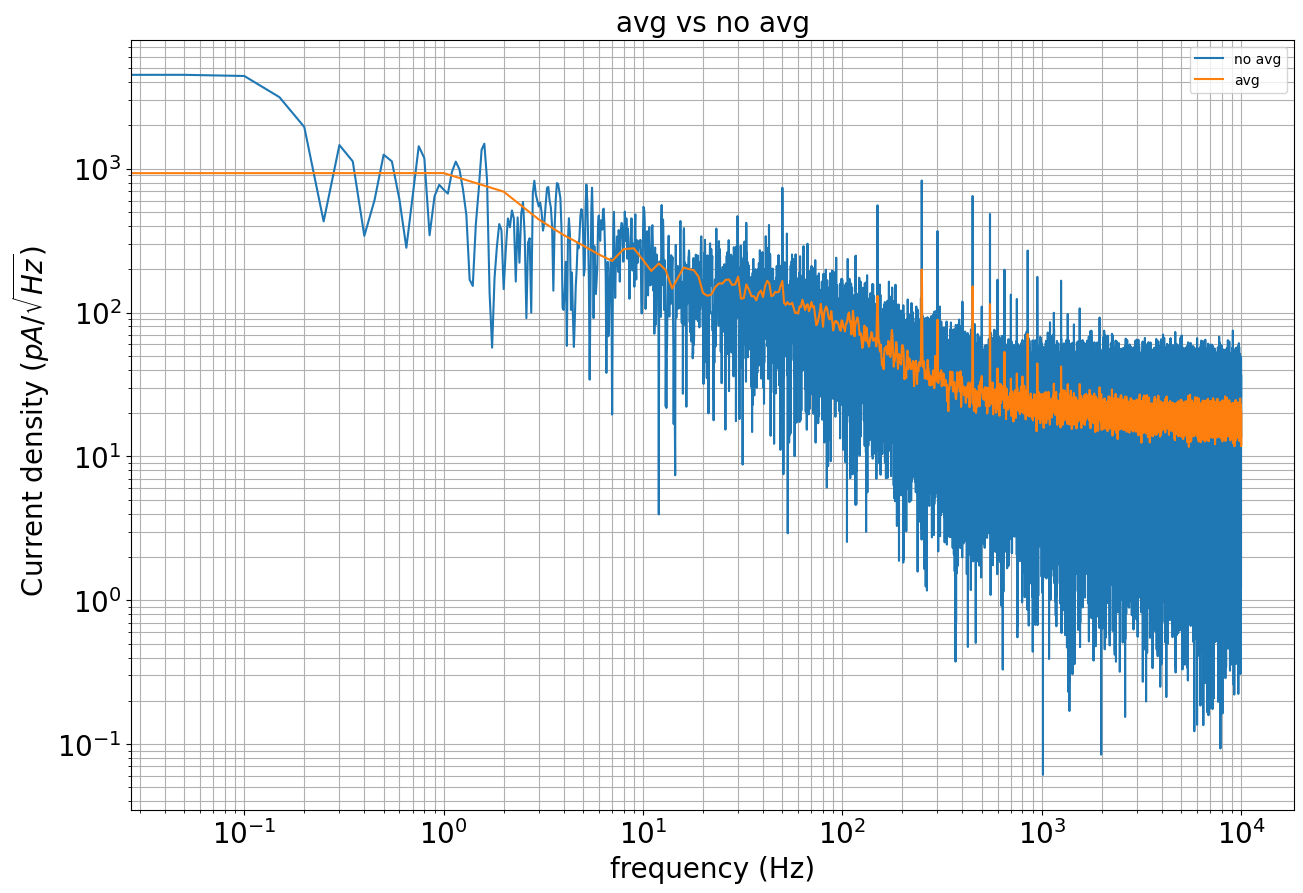

In [315]:
Fs = 20000
BW = 20e6

f_avg,va_avg = PSD_avg(OSCILLO_TES1BA[0]*factor                      , Fs, BW, 20000)
f_noavg, va_noavg = compute_power_spectral_density(OSCILLO_TES1BA[0]*factor, Fs, len(OSCILLO_TES1BA[0]), BW)
print(len(va_noavg))
plt.figure(figsize = (15,10))
plt.title('avg vs no avg', fontsize = 20)
plt.loglog(f_noavg, va_noavg, label = 'no avg')
plt.loglog(f_avg, va_avg, label = 'avg')
# plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor, color = color[1] )
# plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor, color = color[1], label = 'TES 2 ' )
# plt.loglog(f,va)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.legend()
plt.show()

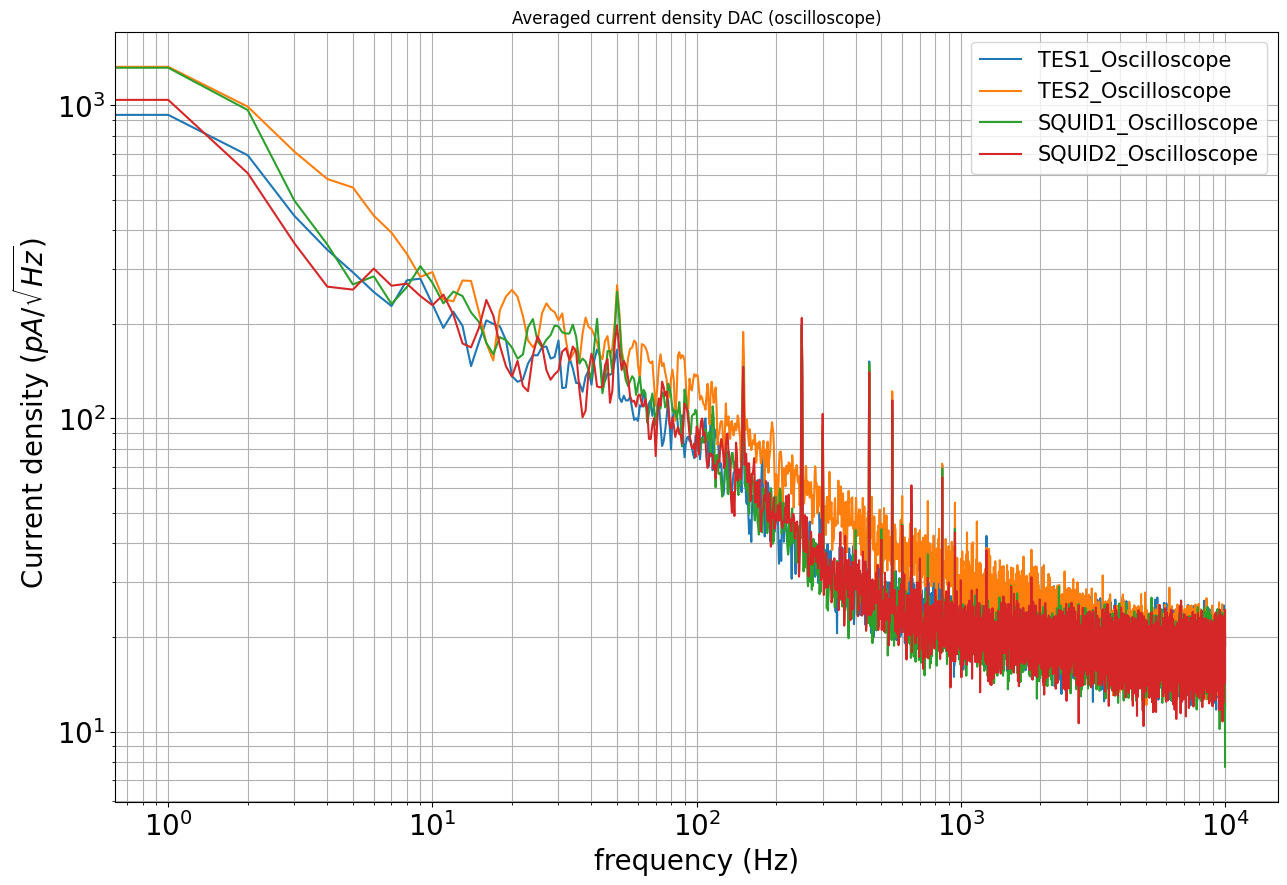

In [316]:
name = [  'TES1_Oscilloscope'
        , 'TES2_Oscilloscope'
        , 'SQUID1_Oscilloscope'
        , 'SQUID2_Oscilloscope']
plt.figure(figsize = (15,10))
plt.title('Averaged current density DAC (oscilloscope)')
for i in range(len(OSCILLO_analyse)):
    f,va = PSD_avg(OSCILLO_analyse[i][0]*factor, Fs, BW, 20000)
    plt.loglog(f,va, label = f'{name[i]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### Compare plot between Spectral analyser and Oscilloscope (board 3 v4.5 with battery)

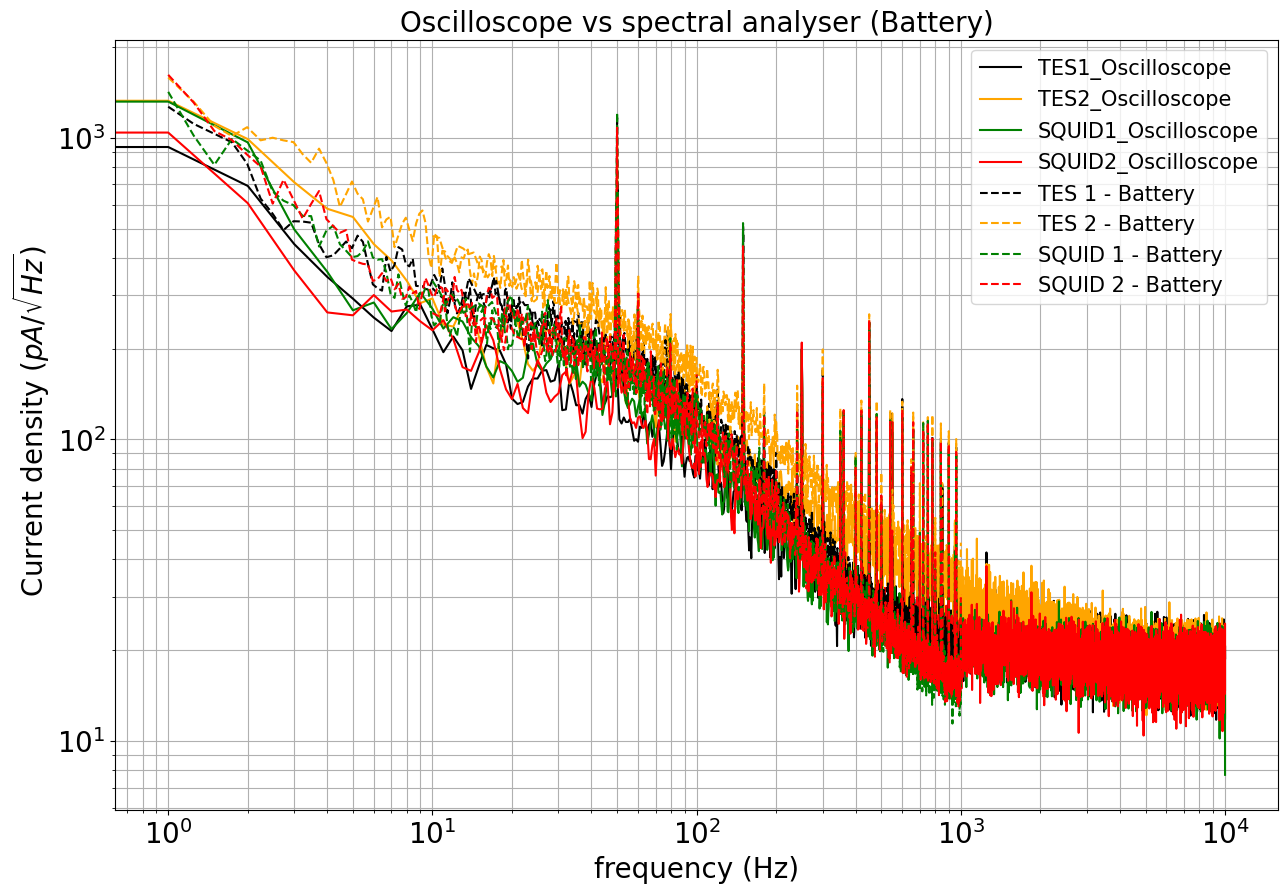

In [317]:
plt
plt.figure(figsize = (15,10))
plt.title('Oscilloscope vs spectral analyser (Battery)', fontsize = 20)
for i in range(len(OSCILLO_analyse)):
    f,va = PSD_avg(OSCILLO_analyse[i][0]*factor, Fs, BW, 20000)
    # f,va = compute_power_spectral_density(OSCILLO_analyse[i][0]*factor, Fs, len(OSCILLO_analyse[i][0]), BW)
    plt.loglog(f,va, color = color[i], label = f'{name[i]}')
#TES_LF 
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[0], label = 'TES 1 - Battery' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[1], label = 'TES 2 - Battery' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[1] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[2], label = 'SQUID 1 - Battery' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor1,linestyle = 'dashed', color = color[3], label = 'SQUID 2 - Battery' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor1,linestyle = 'dashed', color = color[3] )
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

## 1.3.  CMB S4 Board 3

In [379]:
### TES_LF
CMB_TES1PS_LF = np.genfromtxt('data/cmbs4/CMBT0LPS.TXT') 
CMB_TES2PS_LF = np.genfromtxt('data/cmbs4/CMBT1LPS.TXT') 
CMB_TES1PS_HF = np.genfromtxt('data/cmbs4/CMBT0HPS.TXT') 
CMB_TES2PS_HF = np.genfromtxt('data/cmbs4/CMBT1HPS.TXT')
CMB_SQI1PS_LF = np.genfromtxt('data/cmbs4/CMBS0LPS.TXT') 
CMB_SQI2PS_LF = np.genfromtxt('data/cmbs4/CMBS1LPS.TXT')
CMB_SQI1PS_HF = np.genfromtxt('data/cmbs4/CMBS0HPS.TXT') 
CMB_SQI2PS_HF = np.genfromtxt('data/cmbs4/CMBS1HPS.TXT')
CMB_SQI1PS_UF = np.genfromtxt('data/cmbs4/CMBS0UPS.TXT')
CMB_TES2PS_UF = np.genfromtxt('data/cmbs4/CMBT1UPS.TXT')
CMB_SQI2PS_UF = np.genfromtxt('data/cmbs4/CMBS1UPS.TXT') 
CMB_TES1PS_UF = np.genfromtxt('data/cmbs4/CMBT0UPS.TXT') 

CMB_TES1FF_UF = np.genfromtxt('data/cmbs4/CMBT0UFF.TXT') 
CMB_TES1FF_LF = np.genfromtxt('data/cmbs4/CMBT0LFF.TXT') 
CMB_TES1FF_HF = np.genfromtxt('data/cmbs4/CMBT0HFF.TXT')

CMB_SQI1FF_UF = np.genfromtxt('data/cmbs4/CMBS0UFF.TXT') 
CMB_SQI1FF_LF = np.genfromtxt('data/cmbs4/CMBS0LFF.TXT') 
CMB_SQI1FF_HF = np.genfromtxt('data/cmbs4/CMBS0HFF.TXT')

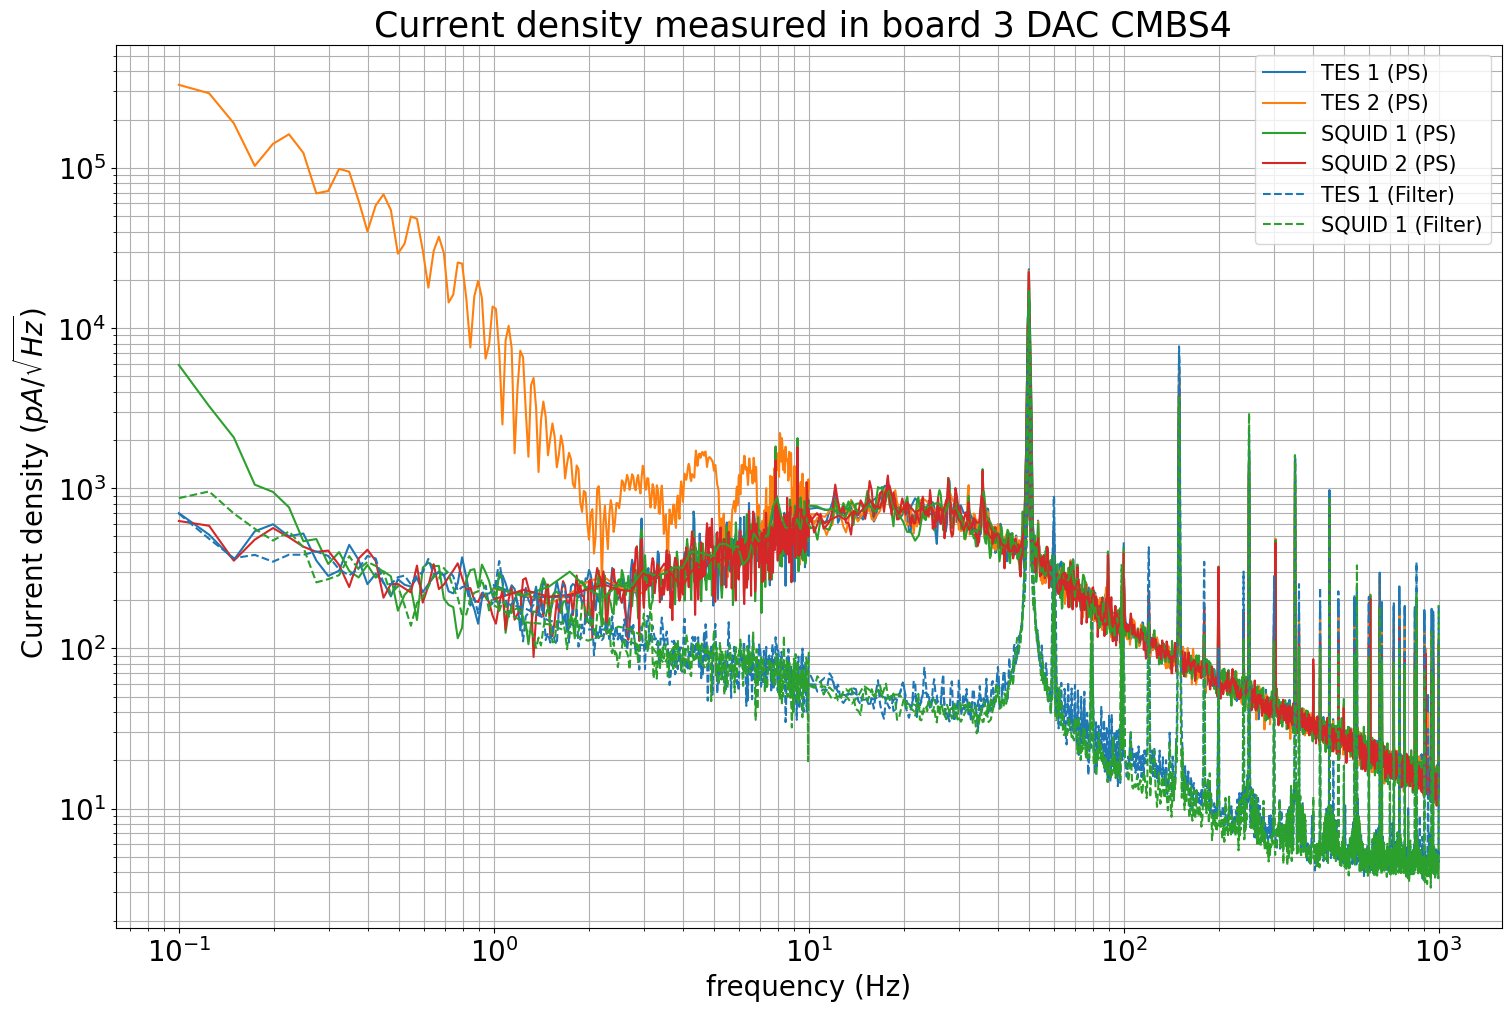

In [380]:
#TES_LF 
plt.figure(figsize = (15,10), constrained_layout=True)
plt.loglog(CMB_TES1PS_UF[:,0], CMB_TES1PS_UF[:,1]*factor1, color = color[0] )
plt.loglog(CMB_TES2PS_UF[:,0], CMB_TES2PS_UF[:,1]*factor1, color = color[1] )
plt.loglog(CMB_TES1PS_LF[:,0], CMB_TES1PS_LF[:,1]*factor1, color = color[0], label = 'TES 1 (PS)' )
plt.loglog(CMB_TES2PS_LF[:,0], CMB_TES2PS_LF[:,1]*factor1, color = color[1], label = 'TES 2 (PS)' )
plt.loglog(CMB_TES1PS_HF[:,0], CMB_TES1PS_HF[:,1]*factor1, color = color[0] )
plt.loglog(CMB_TES2PS_HF[:,0], CMB_TES2PS_HF[:,1]*factor1, color = color[1] )
plt.loglog(CMB_SQI1PS_UF[:,0], CMB_SQI1PS_UF[:,1]*factor1, color = color[2] )
plt.loglog(CMB_SQI2PS_UF[:,0], CMB_SQI2PS_UF[:,1]*factor1, color = color[3] )
plt.loglog(CMB_SQI1PS_LF[:,0], CMB_SQI1PS_LF[:,1]*factor1, color = color[2], label = 'SQUID 1 (PS)' )
plt.loglog(CMB_SQI2PS_LF[:,0], CMB_SQI2PS_LF[:,1]*factor1, color = color[3], label = 'SQUID 2 (PS)' )
plt.loglog(CMB_SQI1PS_HF[:,0], CMB_SQI1PS_HF[:,1]*factor1, color = color[2] )
plt.loglog(CMB_SQI2PS_HF[:,0], CMB_SQI2PS_HF[:,1]*factor1, color = color[3] )

plt.loglog(CMB_TES1FF_UF[:,0], CMB_TES1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES1FF_LF[:,0], CMB_TES1FF_LF[:,1]*factor1, linestyle = 'dashed', color = color[0], label = 'TES 1 (Filter)' )
plt.loglog(CMB_TES1FF_HF[:,0], CMB_TES1FF_HF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_SQI1FF_UF[:,0], CMB_SQI1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[2] )
plt.loglog(CMB_SQI1FF_LF[:,0], CMB_SQI1FF_LF[:,1]*factor1, linestyle = 'dashed', color = color[2], label = 'SQUID 1 (Filter)' )
plt.loglog(CMB_SQI1FF_HF[:,0], CMB_SQI1FF_HF[:,1]*factor1, linestyle = 'dashed', color = color[2] )


plt.gca().set_title('Current density measured in board 3 DAC CMBS4 ',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
# plt.savefig('CMBS4noise_powersupply.png')

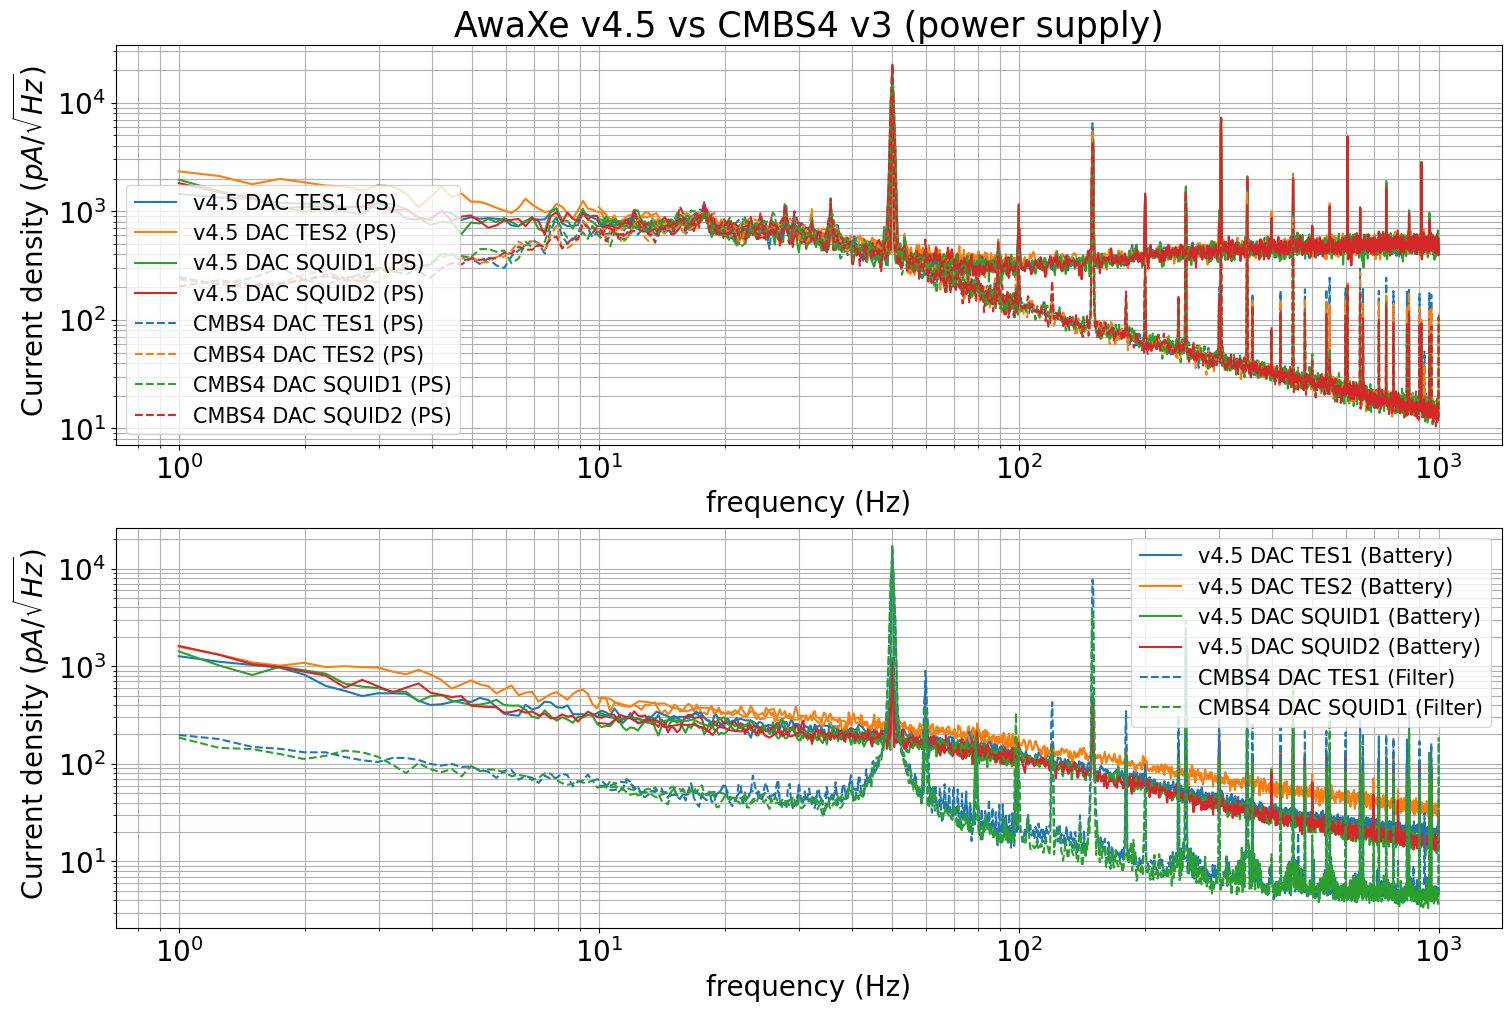

In [391]:
plt.figure(figsize = (15,10), constrained_layout=True)
#TES_LF 
plt.subplot(211)
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor1, color = color[0], label = 'v4.5 DAC TES1 (PS)' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'v4.5 DAC TES2 (PS)' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor1, color = color[2], label = 'v4.5 DAC SQUID1 (PS)' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'v4.5 DAC SQUID2 (PS)' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )



# plt.loglog(CMB_TES1PS_UF[:,0], CMB_TES1PS_UF[:,1]*factor, color = color[0] )
# plt.loglog(CMB_TES2PS_UF[:,0], CMB_TES2PS_UF[:,1]*factor, color = color[1] )

plt.loglog(CMB_TES1PS_LF[:,0], CMB_TES1PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[0], label = 'CMBS4 DAC TES1 (PS)' )
plt.loglog(CMB_TES2PS_LF[:,0], CMB_TES2PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[1], label = 'CMBS4 DAC TES2 (PS)' )
plt.loglog(CMB_TES1PS_HF[:,0], CMB_TES1PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES2PS_HF[:,0], CMB_TES2PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[1] )
plt.loglog(CMB_SQI1PS_LF[:,0], CMB_SQI1PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[2], label = 'CMBS4 DAC SQUID1 (PS)' )
plt.loglog(CMB_SQI2PS_LF[:,0], CMB_SQI2PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[3], label = 'CMBS4 DAC SQUID2 (PS)' )
plt.loglog(CMB_SQI1PS_HF[:,0], CMB_SQI1PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[2] )
plt.loglog(CMB_SQI2PS_HF[:,0], CMB_SQI2PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[3] )


plt.gca().set_title('AwaXe v4.5 vs CMBS4 v3 (power supply)',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor1, color = color[0], label = 'v4.5 DAC TES1 (Battery)' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor1, color = color[1], label = 'v4.5 DAC TES2 (Battery)' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor1, color = color[1] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor1, color = color[2], label = 'v4.5 DAC SQUID1 (Battery)' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor1, color = color[3], label = 'v4.5 DAC SQUID2 (Battery)' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor1, color = color[3] )

# plt.loglog(CMB_TES1FF_UF[:,0], CMB_TES1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES1FF_LF[:,0], CMB_TES1FF_LF[:,1]*factor1, linestyle = 'dashed', color = color[0], label = 'CMBS4 DAC TES1 (Filter)' )
plt.loglog(CMB_TES1FF_HF[:,0], CMB_TES1FF_HF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
# plt.loglog(CMB_SQI1FF_UF[:,0], CMB_SQI1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[2] )
plt.loglog(CMB_SQI1FF_LF[:,0], CMB_SQI1FF_LF[:,1]*factor1, linestyle = 'dashed', color = color[2], label = 'CMBS4 DAC SQUID1 (Filter)' )
plt.loglog(CMB_SQI1FF_HF[:,0], CMB_SQI1FF_HF[:,1]*factor1, linestyle = 'dashed', color = color[2] )

plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
# plt.savefig('AWaXev4.5vsCMBS4v3.png')

In [ ]:
plt.figure(figsize = (15,10), constrained_layout=True)
#TES_LF 
plt.subplot(211)
plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor1, color = color[0], label = 'v4.5 DAC TES1 (PS)' )
plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = color[1], label = 'v4.5 DAC TES2 (PS)' )
#TES_HF 
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = color[1] )
#SQUID_LF 
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor1, color = color[2], label = 'v4.5 DAC SQUID1 (PS)' )
plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = color[3], label = 'v4.5 DAC SQUID2 (PS)' )
#SQUID_HF 
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )



# plt.loglog(CMB_TES1PS_UF[:,0], CMB_TES1PS_UF[:,1]*factor, color = color[0] )
# plt.loglog(CMB_TES2PS_UF[:,0], CMB_TES2PS_UF[:,1]*factor, color = color[1] )

plt.loglog(CMB_TES1PS_LF[:,0], CMB_TES1PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[0], label = 'CMBS4 DAC TES1 (PS)' )
plt.loglog(CMB_TES2PS_LF[:,0], CMB_TES2PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[1], label = 'CMBS4 DAC TES2 (PS)' )
plt.loglog(CMB_TES1PS_HF[:,0], CMB_TES1PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES2PS_HF[:,0], CMB_TES2PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[1] )
plt.loglog(CMB_SQI1PS_LF[:,0], CMB_SQI1PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[2], label = 'CMBS4 DAC SQUID1 (PS)' )
plt.loglog(CMB_SQI2PS_LF[:,0], CMB_SQI2PS_LF[:,1]*factor1, linestyle = 'dashed', color = color[3], label = 'CMBS4 DAC SQUID2 (PS)' )
plt.loglog(CMB_SQI1PS_HF[:,0], CMB_SQI1PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[2] )
plt.loglog(CMB_SQI2PS_HF[:,0], CMB_SQI2PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[3] )


plt.gca().set_title('AwaXe v4.5 vs CMBS4 v3 (power supply)',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor1, color = color[0], label = 'v4.5 DAC TES1 (Battery)' )
plt.loglog(TES2BA_LF[:,0], TES2BA_LF[:,1]*factor1, color = color[1], label = 'v4.5 DAC TES2 (Battery)' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor1, color = color[0] )
plt.loglog(TES2BA_HF[:,0], TES2BA_HF[:,1]*factor1, color = color[1] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor1, color = color[2], label = 'v4.5 DAC SQUID1 (Battery)' )
plt.loglog(SQI2BA_LF[:,0], SQI2BA_LF[:,1]*factor1, color = color[3], label = 'v4.5 DAC SQUID2 (Battery)' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor1, color = color[2] )
plt.loglog(SQI2BA_HF[:,0], SQI2BA_HF[:,1]*factor1, color = color[3] )

# plt.loglog(CMB_TES1FF_UF[:,0], CMB_TES1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES1FF_LF[:,0], CMB_TES1FF_LF[:,1]*factor1, linestyle = 'dashed', color = color[0], label = 'CMBS4 DAC TES1 (Filter)' )
plt.loglog(CMB_TES1FF_HF[:,0], CMB_TES1FF_HF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
# plt.loglog(CMB_SQI1FF_UF[:,0], CMB_SQI1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[2] )
plt.loglog(CMB_SQI1FF_LF[:,0], CMB_SQI1FF_LF[:,1]*factor1, linestyle = 'dashed', color = color[2], label = 'CMBS4 DAC SQUID1 (Filter)' )
plt.loglog(CMB_SQI1FF_HF[:,0], CMB_SQI1FF_HF[:,1]*factor1, linestyle = 'dashed', color = color[2] )

plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
# plt.savefig('AWaXev4.5vsCMBS4v3.png')

In [409]:
def in_dac2out(data,G):
    # print(G)
    G = (1/G)*(1e12) # to not convert to pA
    # print(G)
    thermal_noise =  (4 * 1.38e-23 * 300 / 510)*np.ones(len(data[1])) #A^2 / Hz
    amp_noise = (3.5e-9 / 510)**2 * np.ones(len(data)) # A^2 / Hz
    # i_out = np.sqrt((data / G)**2 - thermal_noise - amp_noise) #A / sqrt(Hz)
    i_out = np.sqrt(data[1]**2*G**2 + thermal_noise + amp_noise)
    # i_out = data[1]**2 + thermal_noise + amp_noise
    return data[0],i_out

## 1.3. Plot intrinsic noise of DAC 

The DAC output density noise is the combination of the intrinsic current noise $i_n$, the thermal noise due to the resistance $R_o$ and the noise added by the Stanford Research amplifier ($e_{nSR2} = 3.5\,$nV/$\sqrt{Hz}$\,@\,1\,kHz) resulting in the equation:
\begin{equation}
     \sqrt{S_I} = \sqrt{i_n^2 + \frac{4 \cdot k_B \cdot T}{510} + \left(\frac{e_{nSR2}}{510}\right)^2}
\end{equation}
Using the previous equations, solving for $i_n$:
\begin{equation}
     i_n = \sqrt{\left(\frac{n_{oDAC}}{G}\right)^2 - \frac{4 \cdot k_B \cdot T}{510} - \left(\frac{3.5 \times 10^{-9}}{510}\right)^2} \quad [{A}/\sqrt{Hz}]
\end{equation}

Knowing $G = 510000$ for input impedance $Z_{in} = 50 \Omega$ and $G = 1020000$ for input impedance $Z_{in} = 1 M \Omega$ (Note that this gain does not include $1e12$ because we are converting output noise to $A/ \sqrt{Hz}$  

In [321]:
def join(data1, data2):
    f1 = data1[:,0]
    a1 = data1[:,1]
    f2 = data2[:,0]
    a2 = data2[:,1]
    f1 = np.array(f1)
    f2 = np.array(f2)
    a1 = np.array(a1)
    a2 = np.array(a2)
    # print(len(a1))
    # Step 1: Find matching indices
    matching_indices = np.where(np.isin(f1, f2))[0]
    
    # Step 2: Calculate average of a1 and a2 for matching indices
    a_avg = (a1[matching_indices] + a2[np.isin(f2, f1)]) / 2
    
    # Step 3: Concatenate non-matching values
    f_combined = np.concatenate((f1, f2[np.isin(f2, f1, invert=True)]))
    a_combined = np.concatenate((a1, a2[np.isin(f2, f1, invert=True)]))
    
    # Concatenate matching values with averaged a values
    f_combined = np.concatenate((f_combined, f1[matching_indices]))
    a_combined = np.concatenate((a_combined, a_avg))
    
    # Sort the combined arrays based on the frequency values
    sort_indices = np.argsort(f_combined)
    f_combined = f_combined[sort_indices]
    a_combined = a_combined[sort_indices]
    return f_combined,a_combined

def join1(data1, data2):
    f1 = data1[0]
    a1 = data1[1]
    f2 = data2[:,0]
    a2 = data2[:,1]
    f1 = np.array(f1)
    f2 = np.array(f2)
    a1 = np.array(a1)
    a2 = np.array(a2)
    # print(len(a1))
    # Step 1: Find matching indices
    matching_indices = np.where(np.isin(f1, f2))[0]
    
    # Step 2: Calculate average of a1 and a2 for matching indices
    a_avg = (a1[matching_indices] + a2[np.isin(f2, f1)]) / 2
    
    # Step 3: Concatenate non-matching values
    f_combined = np.concatenate((f1, f2[np.isin(f2, f1, invert=True)]))
    a_combined = np.concatenate((a1, a2[np.isin(f2, f1, invert=True)]))
    
    # Concatenate matching values with averaged a values
    f_combined = np.concatenate((f_combined, f1[matching_indices]))
    a_combined = np.concatenate((a_combined, a_avg))
    
    # Sort the combined arrays based on the frequency values
    sort_indices = np.argsort(f_combined)
    f_combined = f_combined[sort_indices]
    a_combined = a_combined[sort_indices]
    return f_combined,a_combined

#calculate DAC intrinsic noise
def in_dac(data,G):
    # print(G)
    G = (1/G)*(1e12) # to not convert to pA
    # print(G)
    thermal_noise =  (4 * 1.38e-23 * 300 / 510)*np.ones(len(data)) #A^2 / Hz
    amp_noise = (3.5e-9 / 510)**2 * np.ones(len(data)) # A^2 / Hz
    i_out = np.sqrt((data / G)**2 - thermal_noise - amp_noise) #A / sqrt(Hz)
    return i_out

### 1.4.1. Comparison 

First we do the join of data, to be easier to observe 

Data set for AwaXe v4 (board 4)

In [322]:
V4B4SPS = join(S4LFPS, S4HFPS)
in_V4B4SPS = [V4B4SPS[0], in_dac(V4B4SPS[1], factor1)]

V4B4SFF = join(S4LFFF, S4HFFF)
in_V4B4SFF = [V4B4SFF[0], in_dac(V4B4SFF[1], factor1)] 

V4B4SBA = join(S4LFBA, S4HFBA)
in_V4B4SBA = [V4B4SBA[0], in_dac(V4B4SBA[1], factor1)] 

V4B4TPS = join(T4LFPS, T4HFPS)
in_V4B4TPS = [V4B4TPS[0], in_dac(V4B4TPS[1], factor1)] 

V4B4TFF = join(T4LFFF, T4HFFF)
in_V4B4TFF = [V4B4TFF[0], in_dac(V4B4TFF[1], factor1)] 

V4B4TBA = join(T4LFBA, T4HFBA)
in_V4B4TBA = [V4B4TBA[0], in_dac(V4B4TBA[1], factor1)]

Data set for AwaXe v4.5 (board 3)

In [323]:
#v4.5 board 3 (TES/SQUID) power supply 

V45B3T1PS = join(TES1_LF, TES1_HF)
in_V45B3T1PS = [V45B3T1PS[0], in_dac(V45B3T1PS[1], factor1)]

V45B3S1PS = join(SQI1_LF, SQI1_HF)
in_V45B3S1PS = [V45B3S1PS[0], in_dac(V45B3S1PS[1], factor1)]


V45B3T2PS = np.array(join(TES2_UF, TES2_LF))
V45B3T2PS = join1(V45B3T2PS, TES2_HF)
in_V45B3T2PS = [V45B3T2PS[0], in_dac(V45B3T2PS[1], factor1)]

V45B3S2PS = np.array(join(SQI2_LF, SQI2_HF))
V45B3S2PS = join1(SQI2_UF, V45B3S2PS) 
in_V45B3S2PS = [V45B3S2PS[0], in_dac(V45B3S2PS[1], factor1)]

#v4.5 board 3 (TES/SQUID) battery
V45B3T1BA = np.array(join(TES1BA_UF, TES1BA_LF))
V45B3T1BA = join1(V45B3T1BA, TES1BA_HF)
in_V45B3T1BA = [V45B3T1BA[0], in_dac(V45B3T1BA[1], factor1)]

V45B3T2BA = np.array(join(TES2BA_UF, TES2BA_LF))
V45B3T2BA = join1(V45B3T2BA, TES2BA_HF)
in_V45B3T2BA = [V45B3T2BA[0], in_dac(V45B3T2BA[1], factor1)]

V45B3S1BA = np.array(join(SQI1BA_UF, SQI1BA_LF))
V45B3S1BA = join1(V45B3S1BA, SQI1BA_HF)
in_V45B3S1BA = [V45B3S1BA[0], in_dac(V45B3S1BA[1], factor1)]

V45B3S2BA = np.array(join(SQI2BA_UF, SQI2BA_LF))
V45B3S2BA = join1(V45B3S2BA, SQI2BA_HF)
in_V45B3S2BA = [V45B3S2BA[0], in_dac(V45B3S2BA[1], factor1)]

Data set for CMB S4 board 

In [392]:
CMBS4T1PS = np.array(join(CMB_TES1PS_UF, CMB_TES1PS_LF))
CMBS4T1PS = join1(CMBS4T1PS, CMB_TES1PS_HF)
in_CMBS4T1PS = [CMBS4T1PS[0], in_dac(CMBS4T1PS[1], factor1)]

CMBS4T2PS = np.array(join(CMB_TES2PS_UF, CMB_TES2PS_LF))
CMBS4T2PS = join1(CMBS4T2PS, CMB_TES2PS_HF)
in_CMBS4T2PS = [CMBS4T2PS[0], in_dac(CMBS4T2PS[1], factor1)] 

CMBS4S1PS = np.array(join(CMB_SQI1PS_UF, CMB_SQI1PS_LF))
CMBS4S1PS = join1(CMBS4S1PS, CMB_SQI1PS_HF)
in_CMBS4S1PS = [CMBS4S1PS[0], in_dac(CMBS4S1PS[1], factor1)] 

CMBS4S2PS = np.array(join(CMB_SQI2PS_UF, CMB_SQI2PS_LF))
CMBS4S2PS = join1(CMBS4S2PS, CMB_SQI2PS_HF)
in_CMBS4S2PS = [CMBS4S2PS[0], in_dac(CMBS4S2PS[1], factor1)]

CMBS4T1FF = np.array(join(CMB_TES1FF_UF, CMB_TES1FF_LF))
CMBS4T1FF = join1(CMBS4T1FF, CMB_TES1FF_HF)
in_CMBS4T1FF = [CMBS4T1FF[0], in_dac(CMBS4T1FF[1], factor1)]

CMBS4S1FF = np.array(join(CMB_SQI1FF_UF, CMB_SQI1FF_LF))
CMBS4S1FF = join1(CMBS4S1FF, CMB_SQI1FF_HF)
in_CMBS4S1FF = [CMBS4S1FF[0], in_dac(CMBS4S1FF[1], factor1)]

/var/folders/v4/bwhrmml56zdgg4rlt5zykqp00000gp/T/ipykernel_2720/749430071.py:68: RuntimeWarning: invalid value encountered in sqrt
  i_out = np.sqrt((data / G)**2 - thermal_noise - amp_noise) #A / sqrt(Hz)


In [325]:
in_CMBS4T1PS[0]

array([1.000000e-01, 1.247500e-01, 1.495000e-01, ..., 9.987625e+02,
       9.993812e+02, 1.000000e+03])

In the same time, we've received simulated data from Sichen, it's time to read his data 

In [336]:
SIMU_V3_TESPS  = pd.read_csv(    'data/simu_sichen/DAC_v3_TES_OutputNoise_Iout380uA.csv', skiprows=1, header=None) # No header
SIMU_V3_SQIPS  = pd.read_csv(     'data/simu_sichen/DAC_v3_SQ_OutputNoise_Iout380uA.csv', skiprows=1, header=None) # No header
SIMU_V4_TESPS  = pd.read_csv(    'data/simu_sichen/DAC_v4_TES_OutputNoise_Iout380uA.csv', skiprows=1, header=None) # No header
SIMU_V4_SQIPS  = pd.read_csv(     'data/simu_sichen/DAC_v4_SQ_OutputNoise_Iout380uA.csv', skiprows=1, header=None) # No header
SIMU_V45_TESPS = pd.read_csv('data/simu_sichen/DAC_v4dot5_TES_OutputNoise_Iout380uA.csv', skiprows=1, header=None) # No header
SIMU_V45_SQIPS = pd.read_csv( 'data/simu_sichen/DAC_v4dot5_SQ_OutputNoise_Iout380uA.csv', skiprows=1, header=None) # No header


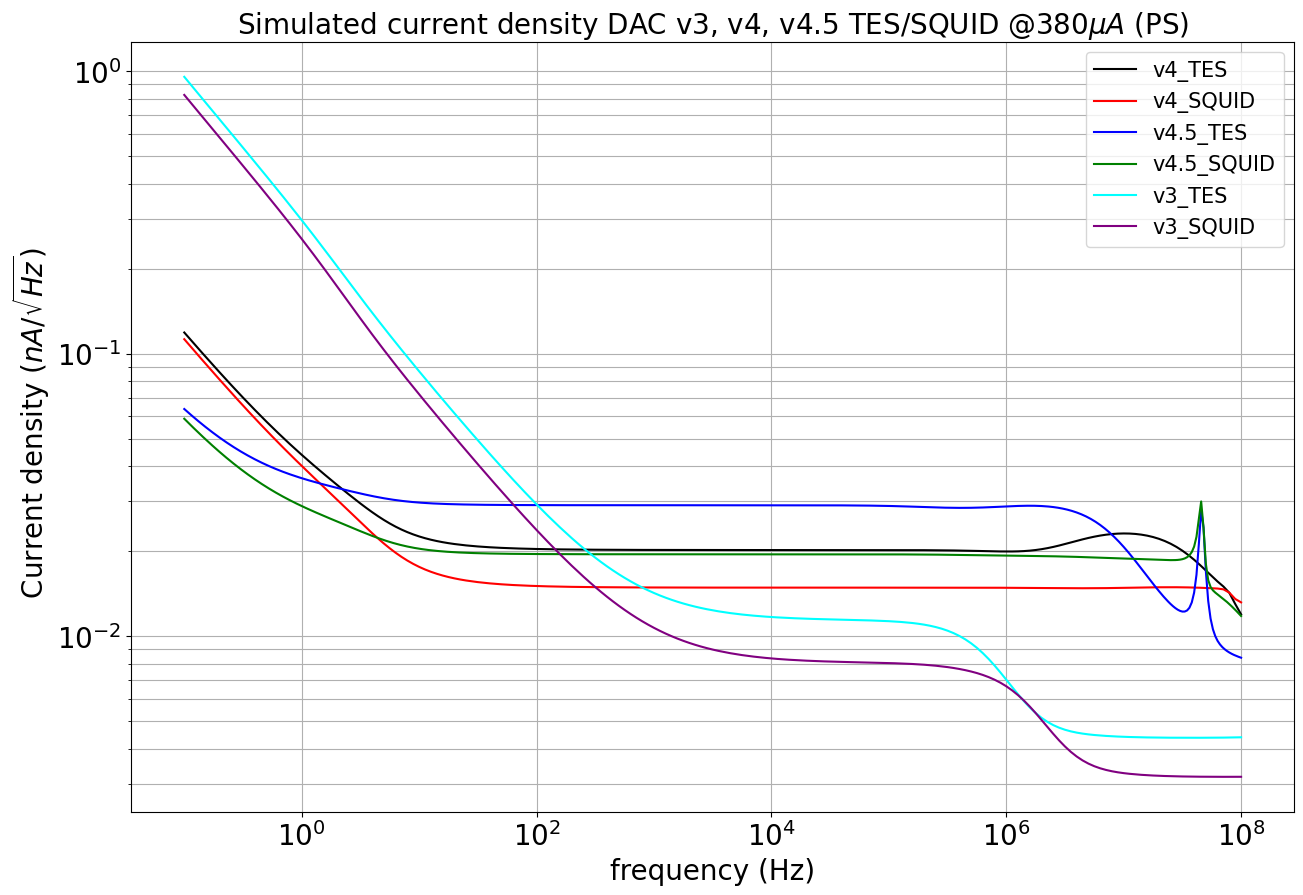

In [365]:
color_si = ['black', 'red', 'blue', 'green', 'cyan', 'purple']
plt.figure(figsize = (15,10))
plt.title(r'Simulated current density DAC v3, v4, v4.5 TES/SQUID @$380 \mu A$ (PS)', fontsize = 20)
# plt.loglog(f,va, label ='Full range')

plt.loglog( SIMU_V4_TESPS[0] , SIMU_V4_TESPS[1]*1e9 , color = color_si[0], label = 'v4_TES')
plt.loglog( SIMU_V4_SQIPS[0] , SIMU_V4_SQIPS[1]*1e9 , color = color_si[1], label = 'v4_SQUID')
plt.loglog(SIMU_V45_TESPS[0] ,SIMU_V45_TESPS[1]*1e9, color =  color_si[2], label = 'v4.5_TES')
plt.loglog(SIMU_V45_SQIPS[0] ,SIMU_V45_SQIPS[1]*1e9, color =  color_si[3], label = 'v4.5_SQUID')
plt.loglog( SIMU_V3_TESPS[0] , SIMU_V3_TESPS[1]*1e9 , color = color_si[4], label = 'v3_TES')
plt.loglog( SIMU_V3_SQIPS[0] , SIMU_V3_SQIPS[1]*1e9 , color = color_si[5], label = 'v3_SQUID')




# plt.xlim(1,1000)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(nA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### 1.4.2. Measurement 

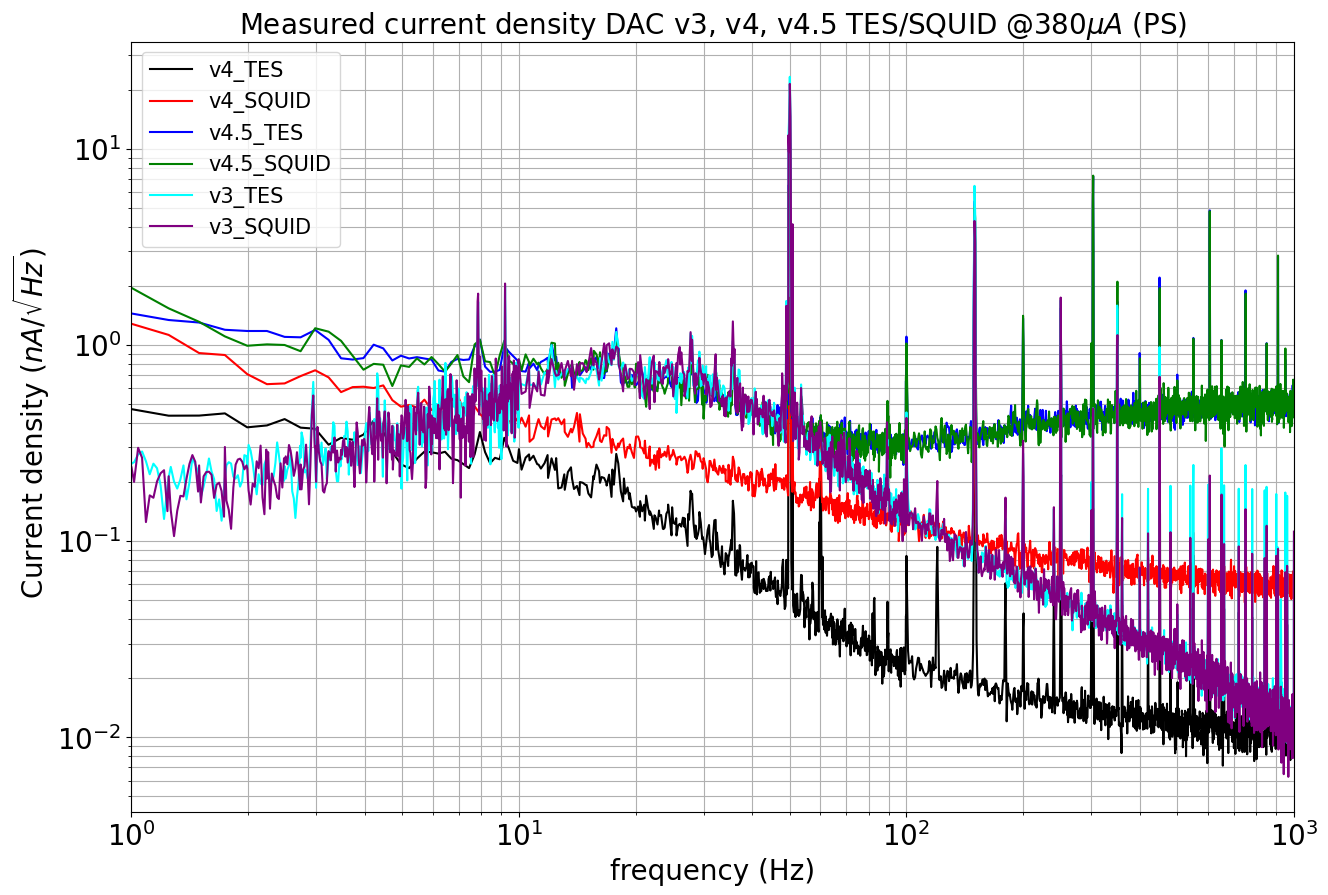

In [361]:
color_si = ['black', 'red', 'blue', 'green', 'cyan', 'purple']
plt.figure(figsize = (15,10))
plt.title(r'Measured current density DAC v3, v4, v4.5 TES/SQUID @$380 \mu A$ (PS)', fontsize = 20)
# plt.loglog(f,va, label ='Full range')

plt.loglog(in_V4B4TPS[0],  in_V4B4TPS[1]*1e9    , color = color_si[0], label = 'v4_TES')
plt.loglog(in_V4B4SPS[0],  in_V4B4SPS[1]*1e9    , color = color_si[1], label = 'v4_SQUID')
plt.loglog(in_V45B3T1PS[0],  in_V45B3T1PS[1]*1e9, color = color_si[2], label = 'v4.5_TES')
plt.loglog(in_V45B3S1PS[0],  in_V45B3S1PS[1]*1e9, color = color_si[3], label = 'v4.5_SQUID')
plt.loglog(in_CMBS4T1PS[0],  in_CMBS4T1PS[1]*1e9, color = color_si[4], label = 'v3_TES')
plt.loglog(in_CMBS4S1PS[0],  in_CMBS4S1PS[1]*1e9, color = color_si[5], label = 'v3_SQUID')



plt.xlim(1,1000)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(nA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

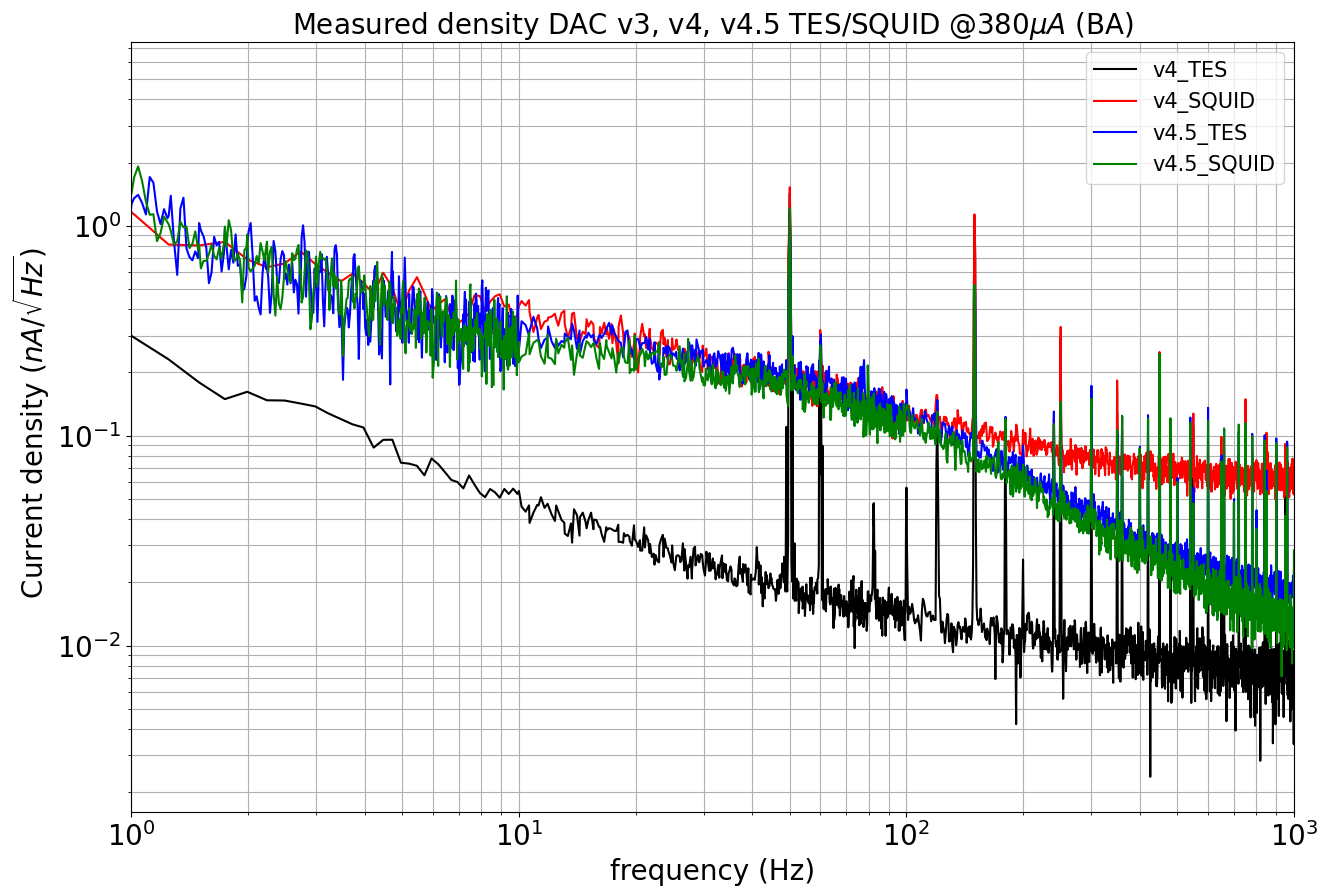

In [362]:
plt.figure(figsize = (15,10))
plt.title(r'Measured density DAC v3, v4, v4.5 TES/SQUID @$380 \mu A$ (BA)', fontsize = 20)
# plt.loglog(f,va, label ='Full range')

plt.loglog(in_V4B4TBA[0],    in_V4B4TBA[1]*1e9    , color = color_si[0], label = 'v4_TES')
plt.loglog(in_V4B4SBA[0],    in_V4B4SBA[1]*1e9    , color = color_si[1], label = 'v4_SQUID')
plt.loglog(in_V45B3T1BA[0],  in_V45B3T1BA[1]*1e9, color = color_si[2], label = 'v4.5_TES')
plt.loglog(in_V45B3S1BA[0],  in_V45B3S1BA[1]*1e9, color = color_si[3], label = 'v4.5_SQUID')
# plt.loglog(in_CMBS4T1BA[0],  in_CMBS4T1BA[1]*1e9, color = color_si[4], label = 'v3_TES')
# plt.loglog(in_CMBS4S1BA[0],  in_CMBS4S1BA[1]*1e9, color = color_si[5], label = 'v3_SQUID')



plt.xlim(1,1000)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(nA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### 1.4.4. Simu vs Measurement

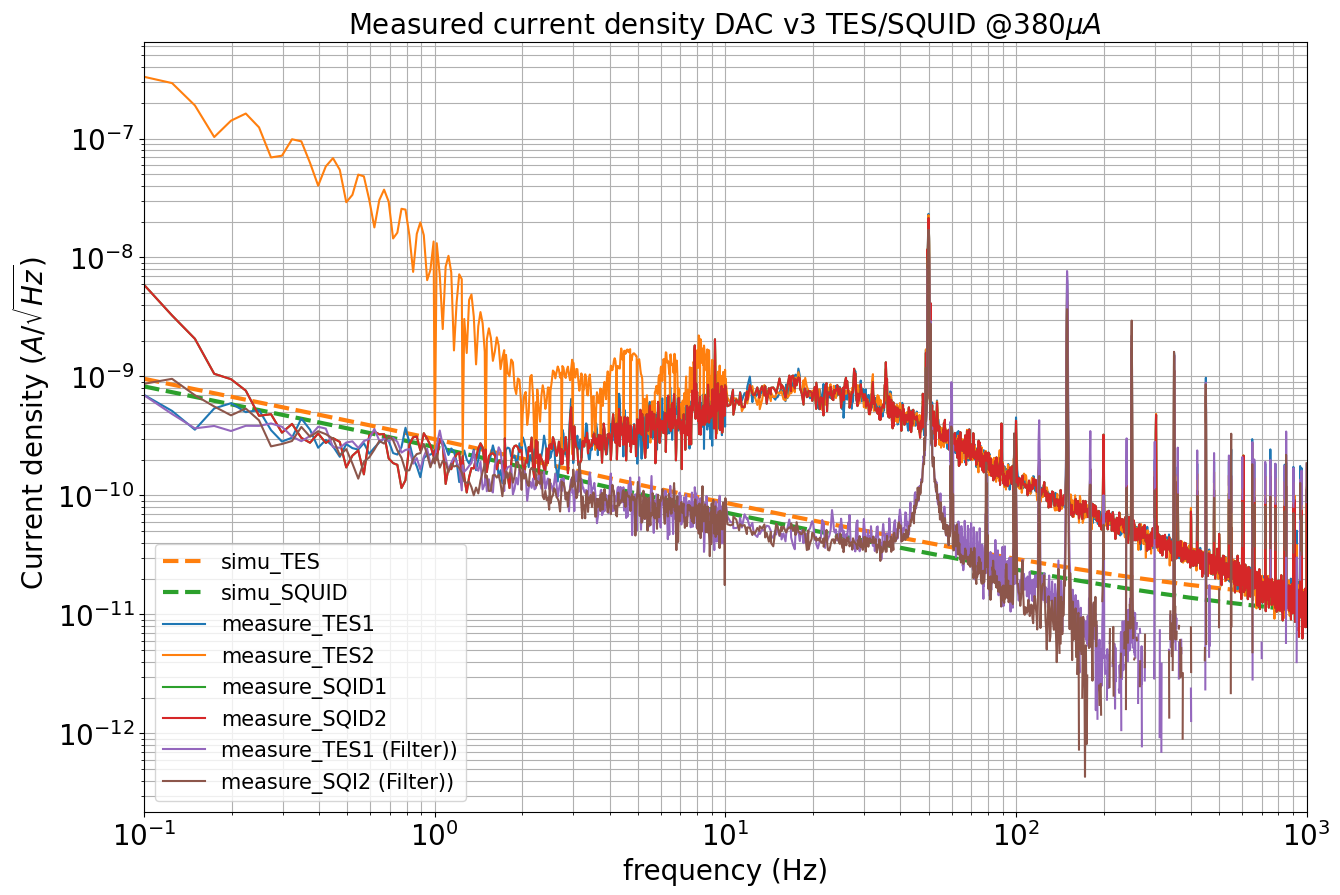

In [393]:
plt.figure(figsize = (15,10))
plt.title(r'Measured current density DAC v3 TES/SQUID @$380 \mu A$', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.loglog(SIMU_V3_TESPS[0], SIMU_V3_TESPS[1],color = color[1], linestyle = 'dashed', lw = 3 , label ='simu_TES')
plt.loglog(SIMU_V3_SQIPS[0], SIMU_V3_SQIPS[1],color = color[2], linestyle = 'dashed', lw = 3 , label ='simu_SQUID')


plt.loglog(in_CMBS4T1PS[0],  in_CMBS4T1PS[1], label = 'measure_TES1')
plt.loglog(in_CMBS4T2PS[0],  in_CMBS4T2PS[1], label = 'measure_TES2')
plt.loglog(in_CMBS4S1PS[0],  in_CMBS4S1PS[1], label = 'measure_SQID1')
plt.loglog(in_CMBS4S1PS[0],  in_CMBS4S1PS[1], label = 'measure_SQID2')

plt.loglog(in_CMBS4T1FF[0],  in_CMBS4T1FF[1], label = 'measure_TES1 (Filter))')
plt.loglog(in_CMBS4S1FF[0],  in_CMBS4S1FF[1], label = 'measure_SQI2 (Filter))')
plt.xlim(0.1,1000)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(A/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

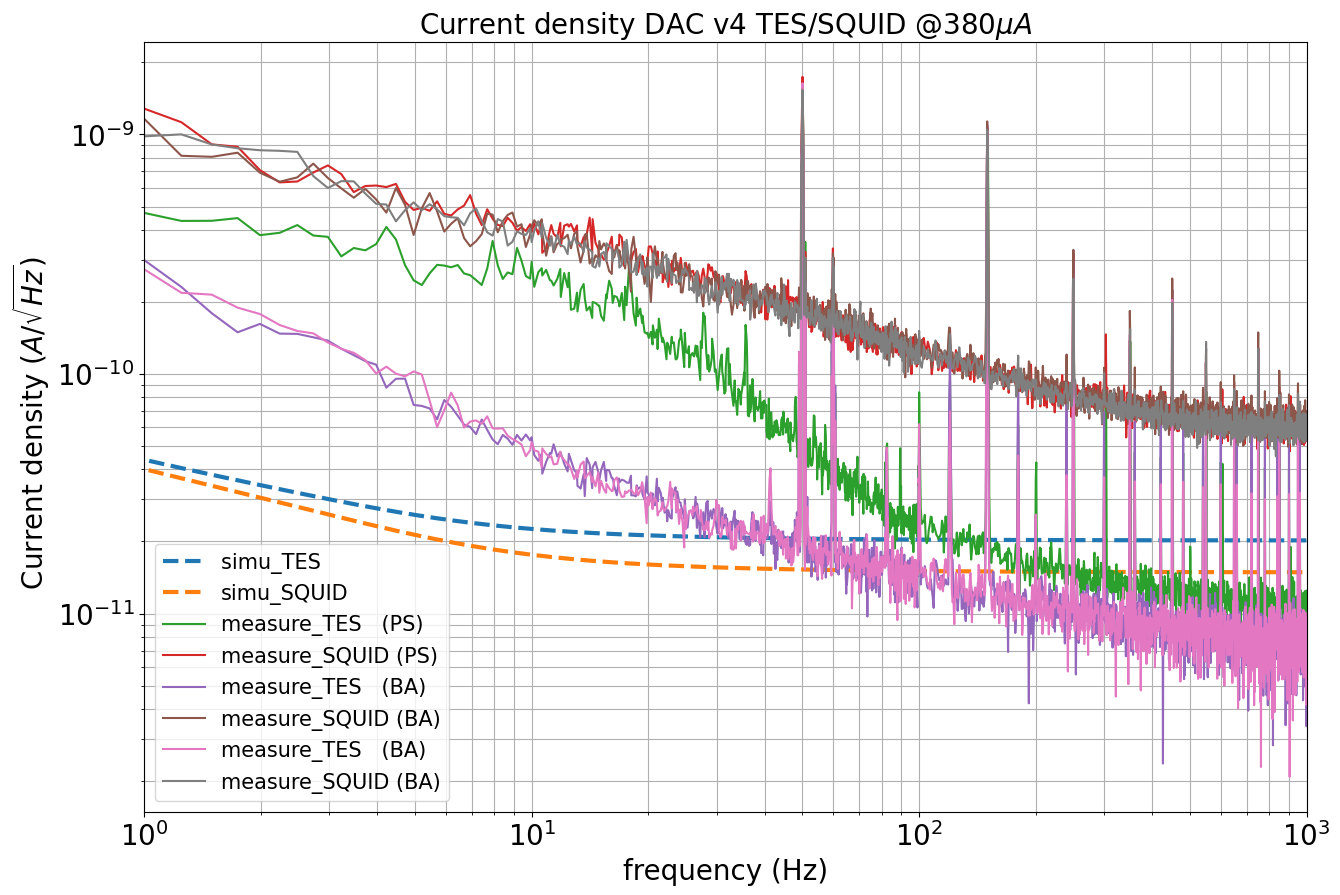

In [340]:
plt.figure(figsize = (15,10))
plt.title(r'Current density DAC v4 TES/SQUID @$380 \mu A$', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.loglog(SIMU_V4_TESPS[0], SIMU_V4_TESPS[1], color = color[0], linestyle = 'dashed' , lw = 3, label ='simu_TES  ')
plt.loglog(SIMU_V4_SQIPS[0], SIMU_V4_SQIPS[1], color = color[1], linestyle = 'dashed' , lw = 3, label ='simu_SQUID')

plt.loglog(in_V4B4TPS[0],  in_V4B4TPS[1], color = color[2], label = 'measure_TES   (PS)')
plt.loglog(in_V4B4SPS[0],  in_V4B4SPS[1], color = color[3], label = 'measure_SQUID (PS)')

plt.loglog(in_V4B4TBA[0],  in_V4B4TBA[1], color = color[4], label = 'measure_TES   (BA)')
plt.loglog(in_V4B4SBA[0],  in_V4B4SBA[1], color = color[5], label = 'measure_SQUID (BA)')

plt.loglog(in_V4B4TFF[0],  in_V4B4TFF[1], color = color[6], label = 'measure_TES   (BA)')
plt.loglog(in_V4B4SFF[0],  in_V4B4SFF[1], color = color[7], label = 'measure_SQUID (BA)')
plt.xlim(1,1000)


plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(A/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

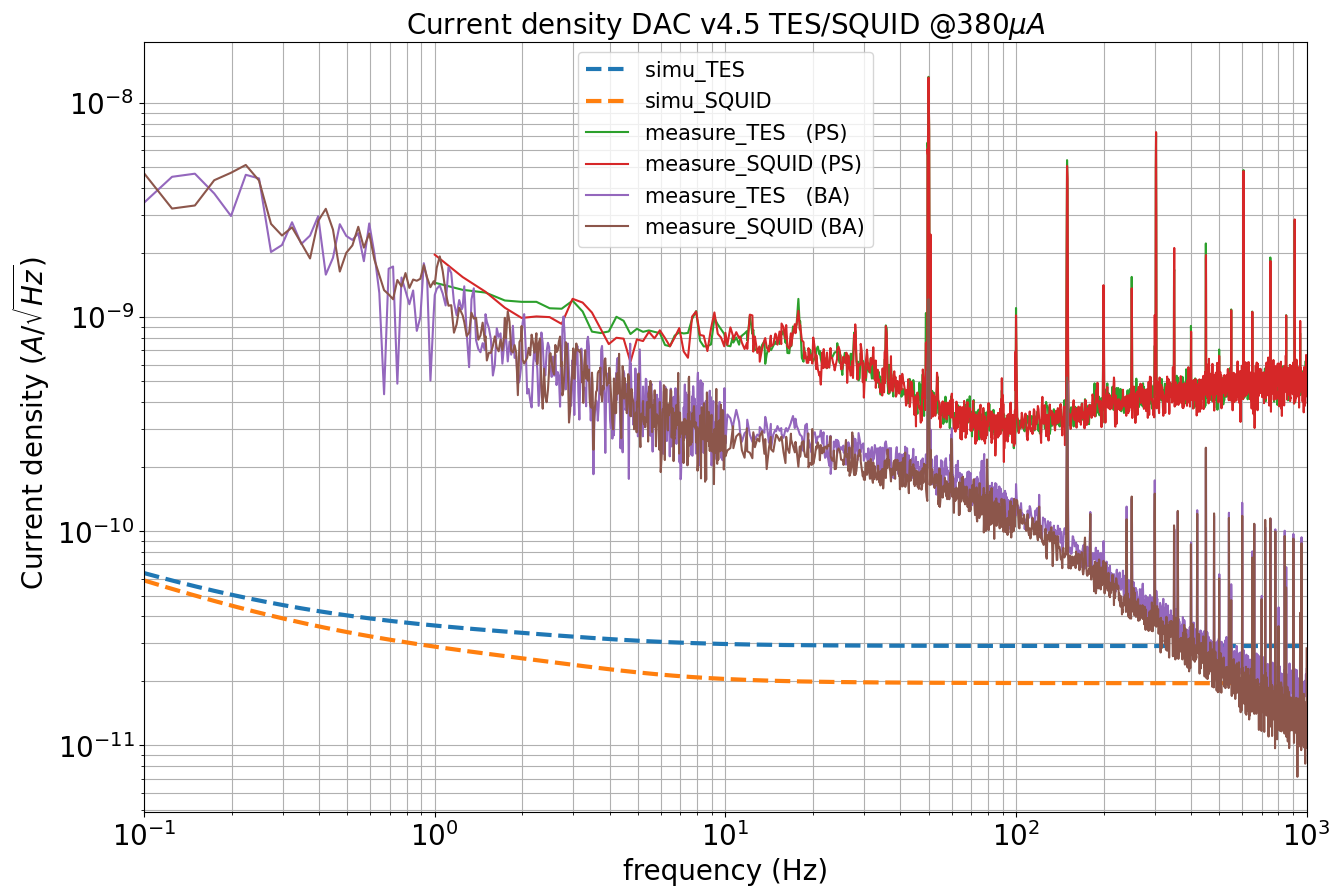

In [344]:
plt.figure(figsize = (15,10))
plt.title(r'Current density DAC v4.5 TES/SQUID @$380 \mu A$', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.loglog(SIMU_V45_TESPS[0], SIMU_V45_TESPS[1], color = color[0], linestyle = 'dashed' , lw = 3, label ='simu_TES  ')
plt.loglog(SIMU_V45_SQIPS[0], SIMU_V45_SQIPS[1], color = color[1], linestyle = 'dashed' , lw = 3, label ='simu_SQUID')

plt.loglog(in_V45B3T1PS[0],  in_V45B3T1PS[1], color = color[2], label = 'measure_TES   (PS)')
plt.loglog(in_V45B3S1PS[0],  in_V45B3S1PS[1], color = color[3], label = 'measure_SQUID (PS)')


plt.loglog(in_V45B3T1BA[0],  in_V45B3T1BA[1], color = color[4], label = 'measure_TES   (BA)')
plt.loglog(in_V45B3S1BA[0],  in_V45B3S1BA[1], color = color[5], label = 'measure_SQUID (BA)')

# plt.loglog(in_V4B4TBA[0],  in_V4B4TBA[1], color = color[4], label = 'measure_TES   (BA)')
# plt.loglog(in_V4B4SBA[0],  in_V4B4SBA[1], color = color[5], label = 'measure_SQUID (BA)')

# plt.loglog(in_V4B4TFF[0],  in_V4B4TFF[1], color = color[6], label = 'measure_TES   (BA)')
# plt.loglog(in_V4B4SFF[0],  in_V4B4SFF[1], color = color[7], label = 'measure_SQUID (BA)')
plt.xlim(0.1,1000)


plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(A/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")



# Appendix

## A. 1. Side analyse 
 

### A.1.1. Compare PSD of full range signal and averaged in time domain signal 
This analyse, we are going to compare the power spectral density of two signal 
* Signal that averaged in time domain (averaging 10 different time domain waveform)
* Single waveform in time domain



In [103]:
count = 0
avg_timedomain = np.zeros(Fs)
for i in range(len(OSCILLO_TES1BA[0]) // 20000):
    avg_timedomain +=  np.array(OSCILLO_TES1BA[0][count:count + Fs])
    count += Fs
avg_timedomain = avg_timedomain / (len(OSCILLO_TES1BA[0]) // 20000)


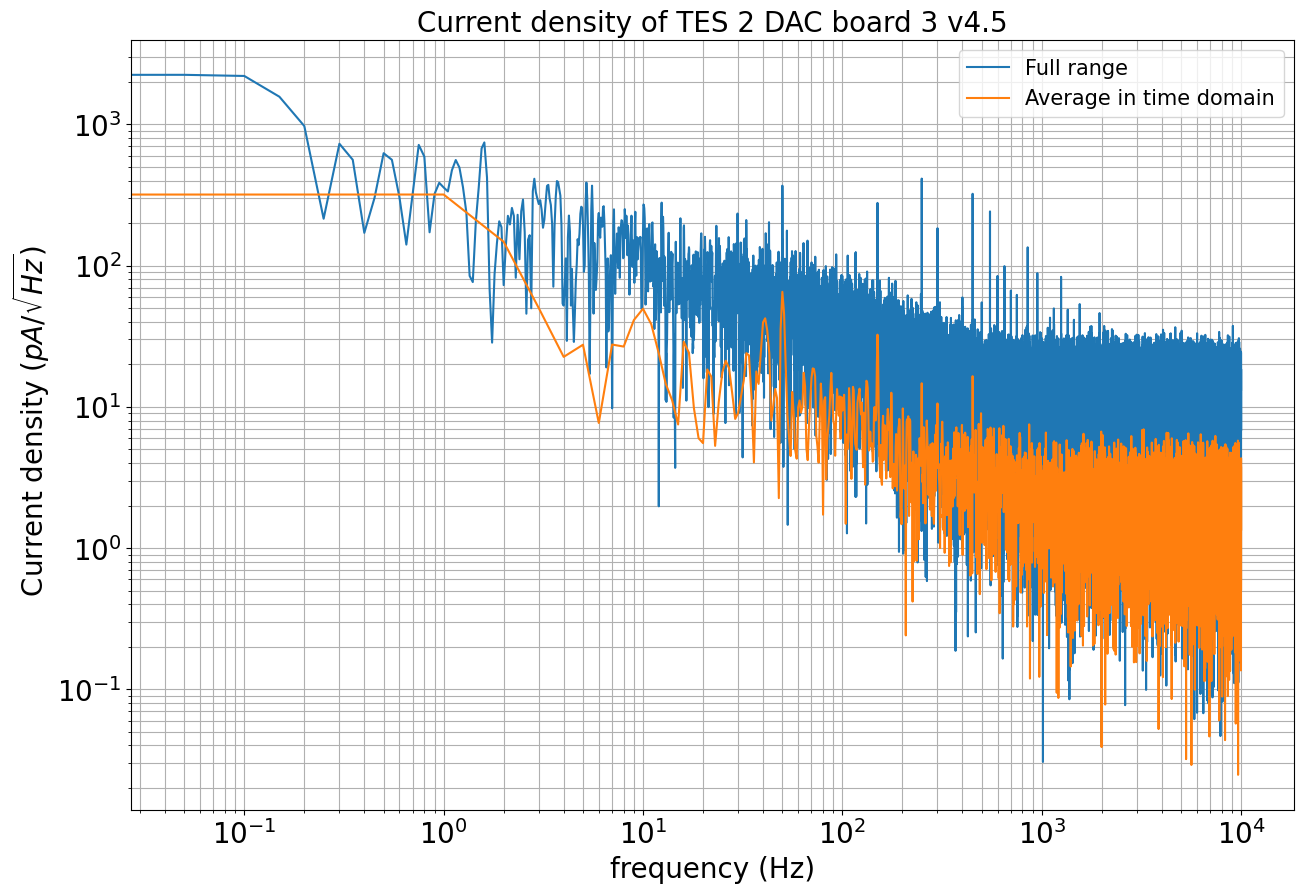

In [108]:
# plt.plot(avg_timedomain)
f,va = PSD_avg(OSCILLO_analyse[0][0]*factor1, Fs, BW, 20000)
f_avg_tdm,va_avg_tdm = compute_power_spectral_density(avg_timedomain*factor1, Fs, len(avg_timedomain), BW)
f_test,va_test = compute_power_spectral_density(OSCILLO_TES1BA[0]*factor1, Fs, len(OSCILLO_TES1BA[0]), BW)

plt.figure(figsize = (15,10))
plt.title('Current density of TES 2 DAC board 3 v4.5', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.loglog(f_test,va_test, label ='Full range')
plt.loglog(f_avg_tdm,va_avg_tdm, label ='Average in time domain')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
# plt.legend()
plt.savefig('signalvsaverage.png')

### A.1.2. Compare PSD of signal measured from Oscilloscope and Spectral Analyser 

This measurment conducted in purpose in measure the current density of DAC with Oscilloscope and Spectral Analyser in the same condition 

-------

Board in use: ``` AwaXe v4.5 ```, board ``` number 3 ```

-------



####  A.1.2a. Compare the signal splitted after the Amplifier SR560

Condition:

* ```SR560``` with ``` G = 1000 ``` and ``` fc = 3 kHz ``` ($ 6 dB$ rolloff)
* DC coupling $1 M \Omega$ in both SA and Os
* Oscilloscope with ``` BW = 20 MHz ``` and ``` fs = 20 kHz ```

In [110]:
#SA
CMPT1LF = np.genfromtxt('data/compare_OS_SA/CMPT1LF.TXT')
CMPT1HF = np.genfromtxt('data/compare_OS_SA/CMPT1HF.TXT')
CMPT1UF = np.genfromtxt('data/compare_OS_SA/CMPT1UF.TXT')
#Os
CMP_OA01 = pd.read_csv('data/compare_OS_SA/cmpt1a01.Wfm.csv', skiprows=0, header=None) # No header
CMP_OA10 = pd.read_csv('data/compare_OS_SA/345t1a10i1M.Wfm.csv', skiprows=0, header=None) # No header

The data measured in oscilloscope were taken by 1 samples (``` CMP_OA1 ```) and average of 10 samples (``` CMP_OA10 ```). We are going to do the comparison between their PSD

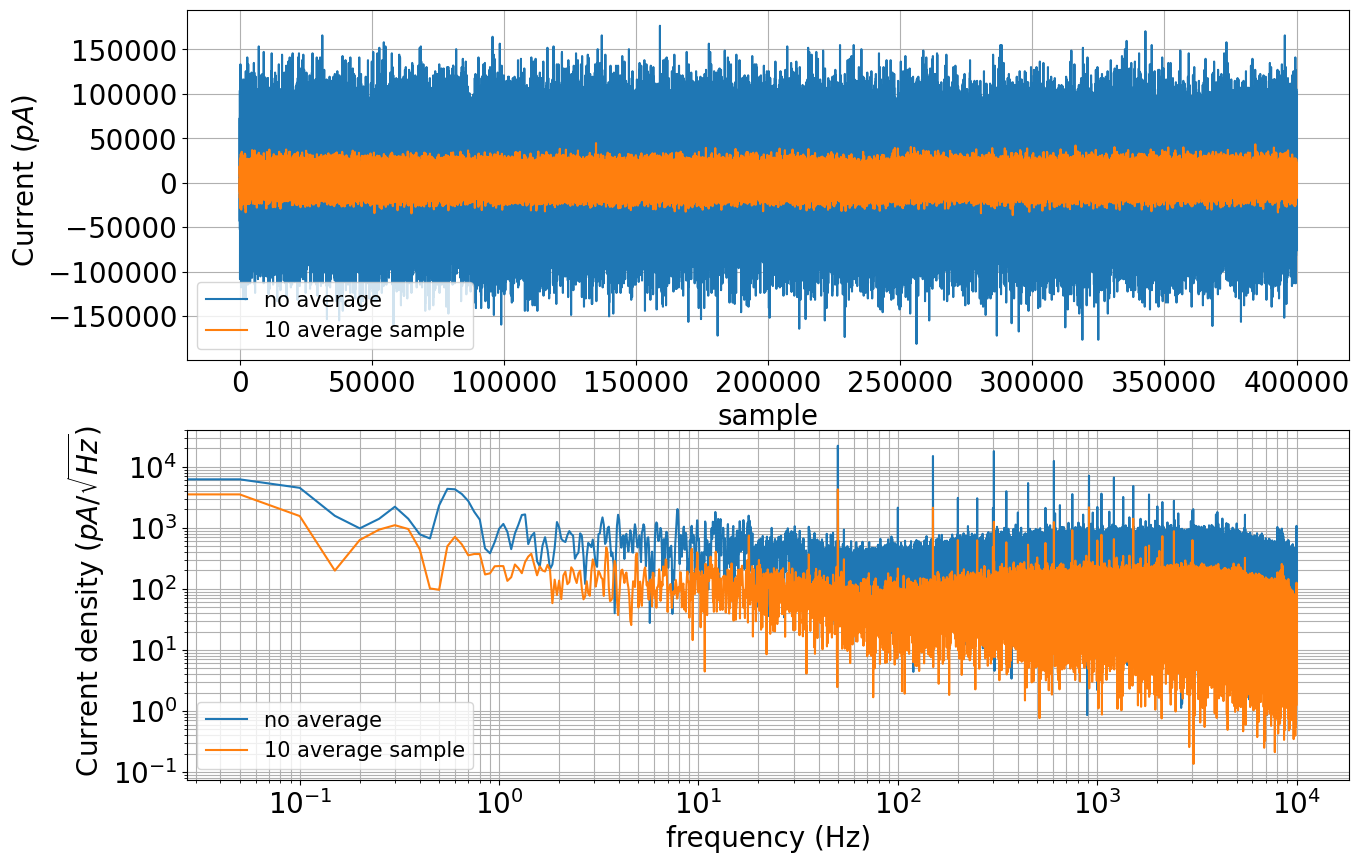

In [115]:
f_CMP_OA01, va_CMP_OA01 = compute_power_spectral_density(CMP_OA01[0]*factor1, Fs, len(CMP_OA01[0]), BW)
f_CMP_OA10, va_CMP_OA10 = compute_power_spectral_density(CMP_OA10[0]*factor1, Fs, len(CMP_OA10[0]), BW)

plt.figure(figsize = (15,10))
plt.subplot(211)
plt.plot(CMP_OA01[0]*factor1, label = 'no average')
plt.plot(CMP_OA10[0]*factor1, label = '10 average sample')
# plt.title('Oscilloscope no avg vs 10 avg', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.xlabel('sample',fontsize = 20)
plt.ylabel(r' Current $(pA)$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.loglog(f_CMP_OA01,va_CMP_OA01 , label = 'no average')
plt.loglog(f_CMP_OA10,va_CMP_OA10 , label = '10 average sample')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

The plot clearly showed the decrease of signal when it averaged by 10 time-domain waveform

We are now compare with the one from Spectral Analyser

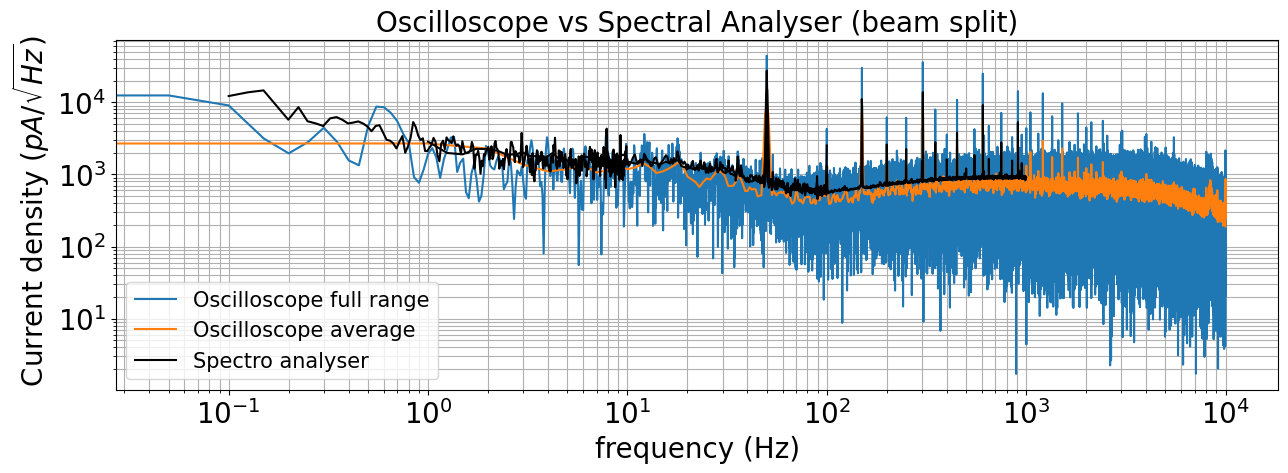

In [51]:
f_CMP_OA01_AVG, va_CMP_OA01_AVG = PSD_avg(CMP_OA01[0]*factor, Fs, BW, 20000)
f_CMP_OA10_AVG, va_CMP_OA10_AVG = PSD_avg(CMP_OA10[0]*factor, Fs, BW, 20000)
plt.figure(figsize = (15,10))
plt.subplot(211)
plt.gca().set_title('Oscilloscope vs Spectral Analyser (beam split)',fontsize = 20)
plt.loglog(f_CMP_OA01,va_CMP_OA01 , label = 'Oscilloscope full range')
plt.loglog(f_CMP_OA01_AVG, va_CMP_OA01_AVG, label = 'Oscilloscope average')
plt.loglog(CMPT1UF[:,0], CMPT1UF[:,1]*factor, color = color[0])
plt.loglog(CMPT1LF[:,0], CMPT1LF[:,1]*factor, color = color[0])
plt.loglog(CMPT1HF[:,0], CMPT1HF[:,1]*factor, color = color[0], label = 'Spectro analyser')
# plt.title('Oscilloscope no avg vs 10 avg', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

Average signal calculated seems to have the same level to the one from the spectral analyser. We are now move to the next comparison

####  A.1.2b. Compare the signal that go directly to the device after amplified by SR560

Condition:

* ```SR560``` with ``` G = 1000 ``` and ``` fc = 3 kHz ``` ($ 6 dB$ rolloff)
* DC coupling $1 M \Omega$ in both SA and Os
* Oscilloscope with ``` BW = 20 MHz ``` and ``` fs = 20 kHz ```

In [117]:
#SA
INDT1LF = np.genfromtxt('data/compare_OS_SA/345T1LF.TXT')
INDT1HF = np.genfromtxt('data/compare_OS_SA/345T1HF.TXT')
INDT1UF = np.genfromtxt('data/compare_OS_SA/345T1UF.TXT')
#Os
IND_OA01 = pd.read_csv( 'data/compare_OS_SA/345t1a01.Wfm.csv', skiprows=0, header=None) # No header
IND_OA10 = pd.read_csv( 'data/compare_OS_SA/345t1a10.Wfm.csv', skiprows=0, header=None) # No header
IND_OA100 = pd.read_csv('data/compare_OS_SA/345t1a100.Wfm.csv', skiprows=0, header=None) # No header

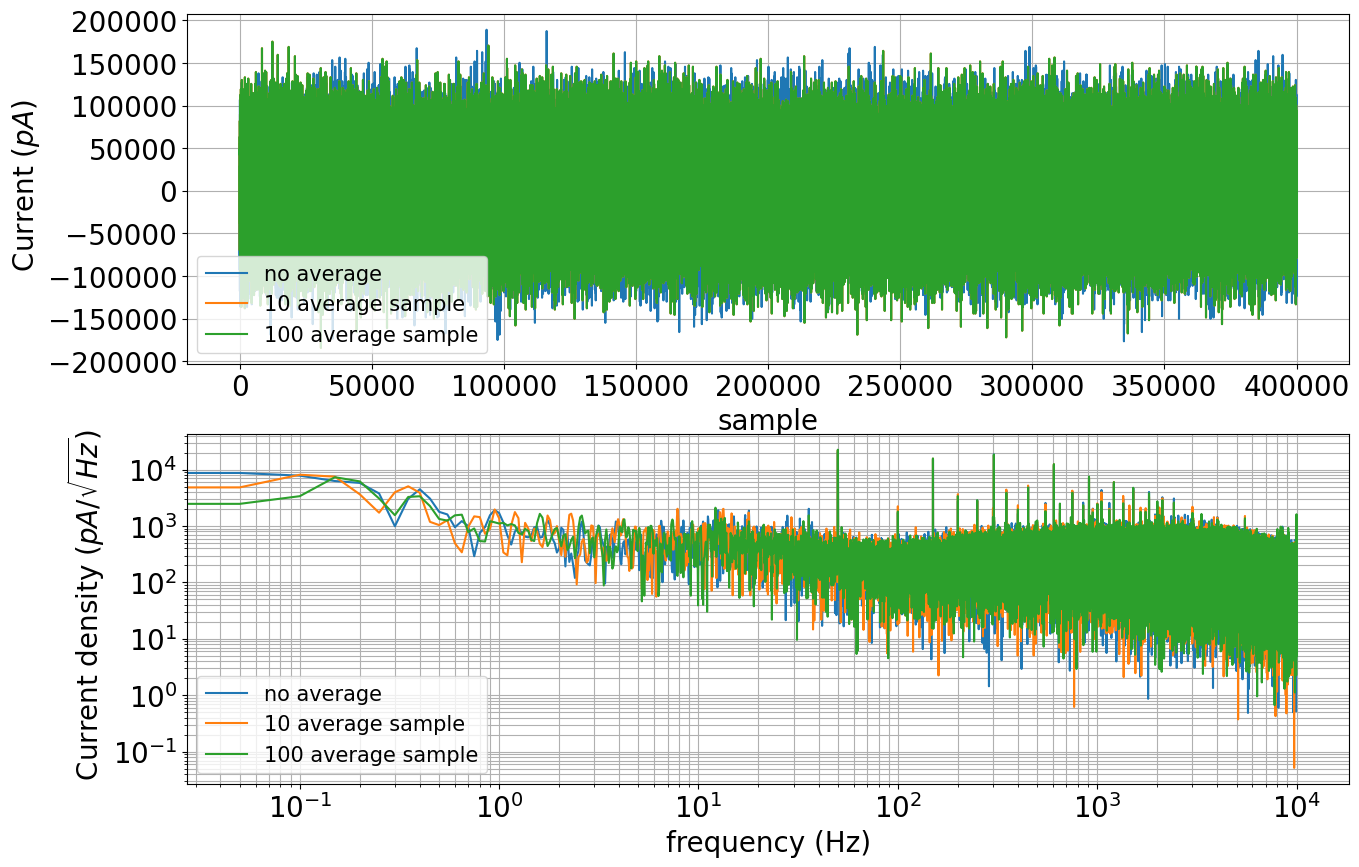

In [119]:
f_IND_OA01, va_IND_OA01 = compute_power_spectral_density(IND_OA01[0]*factor1, Fs, len(IND_OA01[0]), BW)
f_IND_OA10, va_IND_OA10 = compute_power_spectral_density(IND_OA10[0]*factor1, Fs, len(IND_OA10[0]), BW)
f_IND_OA100, va_IND_OA100 = compute_power_spectral_density(IND_OA100[0]*factor1, Fs, len(IND_OA100[0]), BW)

plt.figure(figsize = (15,10))
plt.subplot(211)
plt.plot(IND_OA01[0]*factor1, label = 'no average')
plt.plot(IND_OA10[0]*factor1, label = '10 average sample')
plt.plot(IND_OA10[0]*factor1, label = '100 average sample')
# plt.title('Oscilloscope no avg vs 10 avg', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.xlabel('sample',fontsize = 20)
plt.ylabel(r' Current $(pA)$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.loglog(f_IND_OA01,va_IND_OA01 , label = 'no average')
plt.loglog(f_IND_OA10,va_IND_OA10 , label = '10 average sample')
plt.loglog(f_IND_OA10,va_IND_OA100 , label = '100 average sample')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

still no different? The problem comes from us or devices? 

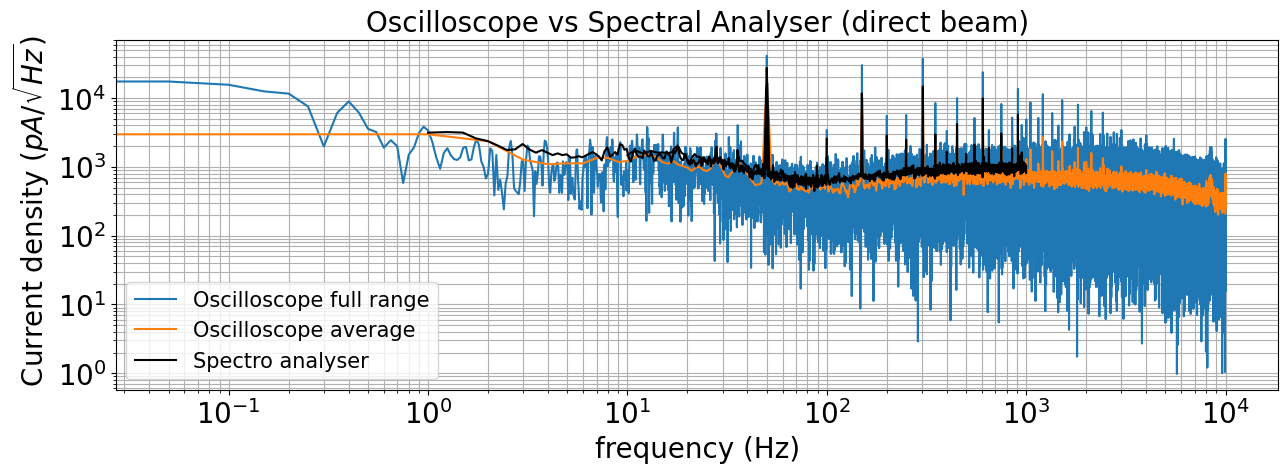

In [57]:
f_IND_OA01_AVG, va_IND_OA01_AVG = PSD_avg(IND_OA01[0]*factor, Fs, BW, 20000)
f_IND_OA10_AVG, va_IND_OA10_AVG = PSD_avg(IND_OA10[0]*factor, Fs, BW, 20000)
f_IND_OA100_AVG, va_IND_OA100_AVG = PSD_avg(IND_OA100[0]*factor, Fs, BW, 20000)
plt.figure(figsize = (15,10))
plt.subplot(211)
plt.gca().set_title('Oscilloscope vs Spectral Analyser (direct beam)',fontsize = 20)
plt.loglog(f_IND_OA01,va_IND_OA01 , label = 'Oscilloscope full range')
plt.loglog(f_IND_OA01_AVG, va_IND_OA01_AVG, label = 'Oscilloscope average')
# plt.loglog(f_CMP_OA01_AVG, va_CMP_OA01_AVG, label = 'Oscilloscope average')
# plt.loglog(INDT1UF[:,0], INDT1UF[:,1]*factor, color = color[0])
plt.loglog(INDT1LF[:,0], INDT1LF[:,1]*factor, color = color[0])
plt.loglog(INDT1HF[:,0], INDT1HF[:,1]*factor, color = color[0], label = 'Spectro analyser')
# plt.title('Oscilloscope no avg vs 10 avg', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

#### A.1.2c. Compare the magnitude of direct beam and the splited one

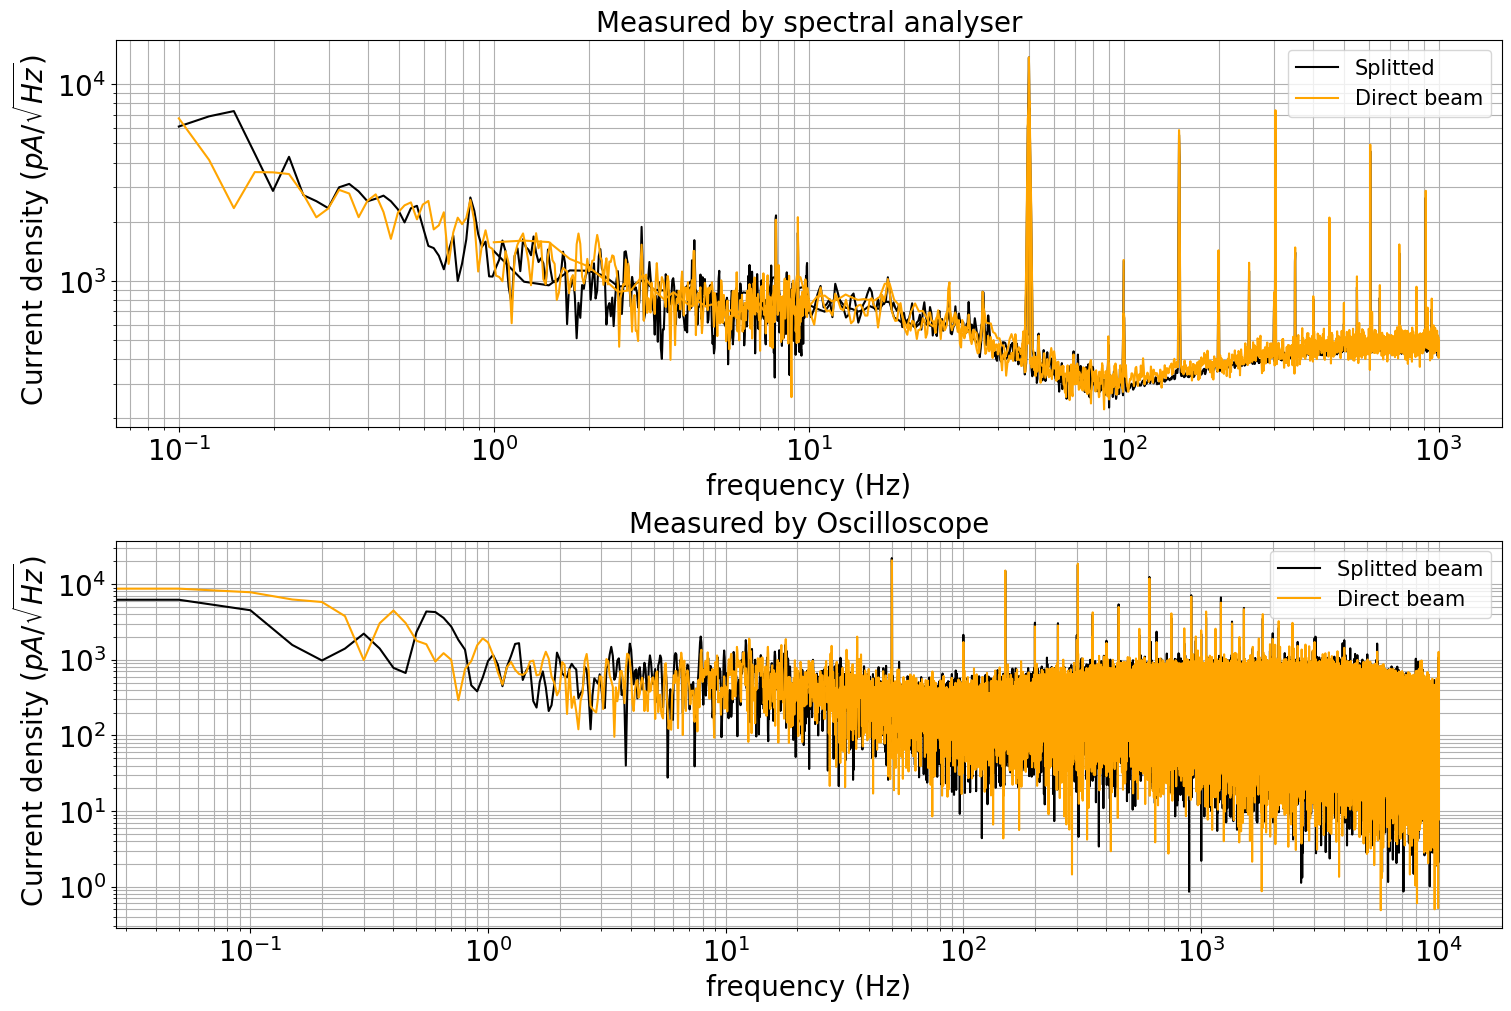

In [120]:
plt.figure(figsize = (15,10), constrained_layout=True)
plt.subplot(211)
plt.gca().set_title('Measured by spectral analyser', fontsize = 20)
plt.loglog(CMPT1UF[:,0], CMPT1UF[:,1]*factor1, color = color[0])
plt.loglog(CMPT1LF[:,0], CMPT1LF[:,1]*factor1, color = color[0])
plt.loglog(CMPT1HF[:,0], CMPT1HF[:,1]*factor1, color = color[0], label = 'Splitted')
plt.loglog(INDT1UF[:,0], INDT1UF[:,1]*factor1, color = color[1])
plt.loglog(INDT1LF[:,0], INDT1LF[:,1]*factor1, color = color[1])
plt.loglog(INDT1HF[:,0], INDT1HF[:,1]*factor1, color = color[1], label = 'Direct beam')
# plt.title('Oscilloscope no avg vs 10 avg', fontsize = 20)
# plt.loglog(f,va, label ='Full range')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.subplot(212)
plt.gca().set_title('Measured by Oscilloscope', fontsize = 20)
plt.loglog(f_CMP_OA01,va_CMP_OA01, color = color[0] , label = 'Splitted beam')
plt.loglog(f_IND_OA01,va_IND_OA01, color = color[1] , label = 'Direct beam')

plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True, which="both")

### Compare output noise v simu

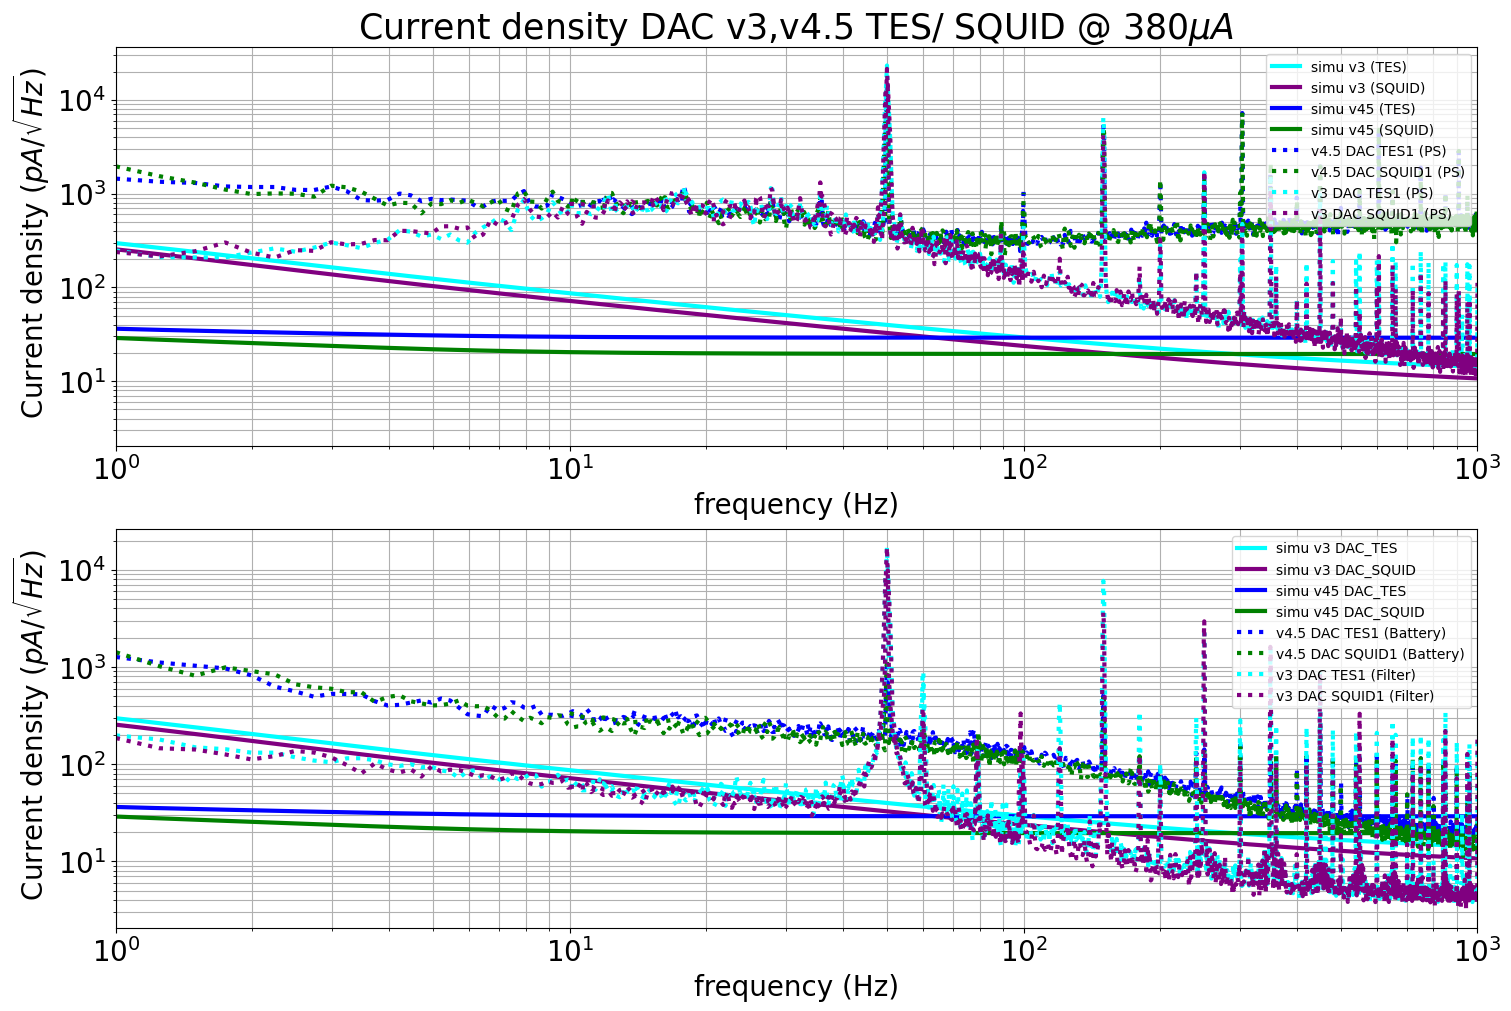

In [451]:
sim_v3_tes = in_dac2out(SIMU_V3_TESPS,factor1)
sim_v3_sqi = in_dac2out(SIMU_V3_SQIPS,factor1)

sim_v45_tes = in_dac2out(SIMU_V45_TESPS,factor1)
sim_v45_sqi = in_dac2out(SIMU_V45_SQIPS,factor1)

plt.figure(figsize = (15,10), constrained_layout=True)
#TES_LF 
plt.subplot(211)

plt.loglog(sim_v3_tes[0], sim_v3_tes[1]*factor1  ,lw = 3, color = color_si[4], label = 'simu v3 (TES)' )
plt.loglog(sim_v3_tes[0], sim_v3_sqi[1]*factor1  ,lw = 3, color = color_si[5], label = 'simu v3 (SQUID)' )
plt.loglog(sim_v45_tes[0], sim_v45_tes[1]*factor1,lw = 3, color = color_si[2], label = 'simu v45 (TES)' )
plt.loglog(sim_v45_tes[0], sim_v45_sqi[1]*factor1,lw = 3, color = color_si[3], label = 'simu v45 (SQUID)' )


plt.loglog(TES1_LF[:,0], TES1_LF[:,1]*factor1, color = color_si[2],linestyle = 'dotted',lw = 3, label = 'v4.5 DAC TES1 (PS)' )
# plt.loglog(TES2_LF[:,0], TES2_LF[:,1]*factor1, color = col_sior[linestyle = 'dotted',lw = 31], label = 'v4.5 DAC TES2 (PS)' )
#TES_HF linestyle = 'dotted',lw = 3_si
plt.loglog(TES1_HF[:,0], TES1_HF[:,1]*factor1, color = color_si[2],linestyle = 'dotted',lw = 3 )
# plt.loglog(TES2_HF[:,0], TES2_HF[:,1]*factor1, color = col_sior[linestyle = 'dotted',lw = 31] )
#SQUID_LF linestyle = 'dotted',lw = 3_si
plt.loglog(SQI1_LF[:,0], SQI1_LF[:,1]*factor1, color = color_si[3],linestyle = 'dotted',lw = 3, label = 'v4.5 DAC SQUID1 (PS)' )
# plt.loglog(SQI2_LF[:,0], SQI2_LF[:,1]*factor1, color = col_sior[linestyle = 'dotted',lw = 33], label = 'v4.5 DAC SQUID2 (PS)' )
#SQUID_HF linestyle = 'dotted',lw = 3_si
plt.loglog(SQI1_HF[:,0], SQI1_HF[:,1]*factor1, color = color_si[3],linestyle = 'dotted',lw = 3 )
# plt.loglog(SQI2_HF[:,0], SQI2_HF[:,1]*factor1, color = color[3] )



# plt.loglog(CMB_TES1PS_UF[:,0], CMB_TES1PS_UF[:,1]*factor, color = color[0] )
# plt.loglog(CMB_TES2PS_UF[:,0], CMB_TES2PS_UF[:,1]*factor, color = color[1] )

plt.loglog(CMB_TES1PS_LF[:,0], CMB_TES1PS_LF[:,1]*factor1,linestyle = 'dotted', lw = 3, color = color_si[4], label = 'v3 DAC TES1 (PS)' )
# plt.loglog(CMB_TES2PS_LF[:,0], CMB_TES2PS_LF[:,1]*facto,linestyle = 'dotted', lw = 3d', color = col_sior[1], label = 'CMBS4 DAC TES2 (PS)' )
plt.loglog(CMB_TES1PS_HF[:,0], CMB_TES1PS_HF[:,1]*factor1,linestyle = 'dotted', lw = 3, color = color_si[4] )
# plt.loglog(CMB_TES2PS_HF[:,0], CMB_TES2PS_HF[:,1]*facto,linestyle = 'dotted', lw = 3d', color = col_sior[1] )
plt.loglog(CMB_SQI1PS_LF[:,0], CMB_SQI1PS_LF[:,1]*factor1,linestyle = 'dotted', lw = 3, color = color_si[5], label = 'v3 DAC SQUID1 (PS)' )
# plt.loglog(CMB_SQI2PS_LF[:,0], CMB_SQI2PS_LF[:,1]*facto,linestyle = 'dotted', lw = 3d', color = col_sior[3], label = 'CMBS4 DAC SQUID2 (PS)' )
plt.loglog(CMB_SQI1PS_HF[:,0], CMB_SQI1PS_HF[:,1]*factor1,linestyle = 'dotted', lw = 3, color = color_si[5] )
# plt.loglog(CMB_SQI2PS_HF[:,0], CMB_SQI2PS_HF[:,1]*factor1, linestyle = 'dashed', color = color[3] )


plt.gca().set_title(r'Current density DAC v3,v4.5 TES/ SQUID @ $380 \mu A$',fontsize = 25)
# plt.loglog(fre, np.sqrt(avg[n]/10), label = f'Board {num[n]}')
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# plt.legend(fontsize = 15)
plt.grid(True, which="both")
plt.xlim(1,1000)
plt.legend(fontsize = 10, loc = 'upper right')
plt.subplot(212)
# plt.gca().set_title('AwaXe v4.5 vs CMBS4 v3 (Battery & Filtered power supply)',fontsize = 25)


plt.loglog(sim_v3_tes[0], sim_v3_tes[1]*factor1  ,lw = 3, color = color_si[4], label = 'simu v3 DAC_TES' )
plt.loglog(sim_v3_tes[0], sim_v3_sqi[1]*factor1  ,lw = 3, color = color_si[5], label = 'simu v3 DAC_SQUID' )
plt.loglog(sim_v45_tes[0], sim_v45_tes[1]*factor1,lw = 3, color = color_si[2], label = 'simu v45 DAC_TES' )
plt.loglog(sim_v45_tes[0], sim_v45_sqi[1]*factor1,lw = 3, color = color_si[3], label = 'simu v45 DAC_SQUID' )

plt.loglog(TES1BA_LF[:,0], TES1BA_LF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[2], label = 'v4.5 DAC TES1 (Battery)' )
plt.loglog(TES1BA_HF[:,0], TES1BA_HF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[2] )
plt.loglog(SQI1BA_LF[:,0], SQI1BA_LF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[3], label = 'v4.5 DAC SQUID1 (Battery)' )
plt.loglog(SQI1BA_HF[:,0], SQI1BA_HF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[3] )


# plt.loglog(CMB_TES1FF_UF[:,0], CMB_TES1FF_UF[:,1]*factor1, linestyle = 'dashed', color = color[0] )
plt.loglog(CMB_TES1FF_LF[:,0], CMB_TES1FF_LF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[4], label = 'v3 DAC TES1 (Filter)' )
plt.loglog(CMB_TES1FF_HF[:,0], CMB_TES1FF_HF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[4] )
plt.loglog(CMB_SQI1FF_LF[:,0], CMB_SQI1FF_LF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[5], label = 'v3 DAC SQUID1 (Filter)' )
plt.loglog(CMB_SQI1FF_HF[:,0], CMB_SQI1FF_HF[:,1]*factor1, linestyle = 'dotted',lw = 3, color = color_si[5] )
plt.xlim(1,1000)
plt.xlabel('frequency (Hz)',fontsize = 20)
plt.ylabel(r' Current density $(pA/ \sqrt{Hz})$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 10, loc = 'upper right')
plt.grid(True, which="both")
plt.savefig('AWaXev4.5vsCMBS4v3_compa_simu.png')



